In [1]:
import os
import itertools
import json
import tqdm
import yaml
import math
from enum import Enum

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm
from dal_toolbox.utils import seed_everything
from dal_toolbox.datasets.utils import FeatureDatasetWrapper
from dal_toolbox.datasets.cifar import CIFAR10Plain

os.makedirs('./learning_curves', exist_ok=True)

base_results_path = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "dal-toolbox", "results", "al_baselines")
hparams_result_path = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "dal-toolbox", "results", "xpal_hparams")

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def load_checkpoint(path, final=True):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    if final:
        exp_pth = path / 'model_final.pth'
    else:
        exp_pth = path / 'checkpoint.pth'
    checkpoint = torch.load(exp_pth)
    return checkpoint

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_results_path(dataset, model, strategy, budget): # Deprecated
    return Path(os.path.join(base_results_path, dataset, model, strategy, f"budget_{budget}"))

def xpal_haparams_new_stand_path(kernel, gamma="", alpha=""): # Deprecated
    return Path(os.path.join(hparams_result_path, "CIFAR10", f"pwc_{alpha}_standardized", "xpal", "budget_100", kernel, gamma))

def xpal_haparams_new_path(kernel, gamma="", alpha=""): # Deprecated
    return Path(os.path.join(hparams_result_path, "CIFAR10", f"pwc_{alpha}", "xpal", "budget_100", kernel, gamma))

def xpal_haparams_path(kernel, gamma=""): # Deprecated
    return Path(os.path.join(hparams_result_path, "CIFAR10", "pwc", "random", "budget_100", kernel, gamma))

def xpal_haparams_standardized_path(kernel, gamma=""): # Deprecated
    return Path(os.path.join(hparams_result_path, "CIFAR10_standardized", "pwc", "random", "budget_100", kernel, gamma))

def xpal_hparams_path(dataset, model="pwc", al_strategy="xpal", init_strategy="random", alpha="1e-3", n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate"):
    return Path(os.path.join(hparams_result_path, f"{dataset}", f"{model}", f"{al_strategy}_{init_strategy}", f"{alpha}", f"N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}", f"{kernel}", f"{gamma}"))

def create_new_results_path(dataset,  model, al_strategy, init_strategy, n_init, acq_size, n_acq, suffix=""):
    return Path(os.path.join(base_results_path, f"{dataset}", f"{model}", f"{al_strategy}_{init_strategy}{f'_{suffix}' if suffix is not '' else ''}", f"N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}"))

In [3]:
def generate_learning_curves(experiments, stats="test_stats", deprecated=False, print_progress=False):
    learning_curves = {}
    for exp_name, path in experiments.items():
        if print_progress:
            print(f"Laoding results for {exp_name} in {path} - ", end = "")
        seed_results = get_experiments(Path(path), glob_pattern='seed*')
        if print_progress:
            print("Calculating - ", end="")
        seed_accuracies = []
        seed_num_labeled = []
        if deprecated:
            for results in seed_results:
                seed_accuracies.append([val['test_stats']['accuracy'] for key, val in results.items()])
                seed_num_labeled.append([val['n_labeled_samples'] for key, val in results.items()])
        else:
            for results in seed_results:
                for key, val in results.items():
                    seed_accuracies.append([val[stats]['accuracy'] for key, val in results.items() if "cycle" in key])
                    seed_num_labeled.append([val['n_labeled_samples'] for key, val in results.items() if "cycle" in key])
            
        metrics = {
            'acc': np.mean(seed_accuracies, axis=0), 
            'acc_std': np.std(seed_accuracies, axis=0), 
            'num_labeled': np.mean(seed_num_labeled, axis=0)
        }
        learning_curves[exp_name] = metrics
        if print_progress:
            print("Done")
    return learning_curves

def plot_learning_curves(learning_curves, xlim=[None], plot_std=True, title="", save=False, savePath=None, loc="best"):
    nrows=1
    ncols=len(xlim)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.5*ncols, 4*nrows), sharex='col', sharey='col', squeeze=False)
    for idx, ax in enumerate(np.array(axes).flatten()):
        for exp_name, metrics in learning_curves.items():
            if xlim[idx] is not None:
                start = np.where(metrics['num_labeled']==xlim[idx][0])[0][0]
                end = np.where(metrics['num_labeled']==xlim[idx][1])[0][0] + 1
            else:
                start = 0
                end = len(metrics['num_labeled'])
                
            ax.plot(metrics['num_labeled'][start:end], metrics['acc'][start:end], '-o', label=exp_name)
            if plot_std:
                ax.fill_between(metrics['num_labeled'][start:end], metrics['acc'][start:end] - metrics['acc_std'][start:end], metrics['acc'][start:end] + metrics['acc_std'][start:end], alpha=.5)
        if idx == 0:
            ax.legend(loc=loc, ncols=len(learning_curves) // 5 + 1)
    
    fig.suptitle(title)
    fig.supxlabel('Number of Annotations')
    fig.supylabel('Accuracy')
    fig.tight_layout()

    if save:
        assert savePath is not None, "savePath has to be specified when saving image"
        plt.savefig(savePath)

    plt.show()

In [4]:
class Dataset(Enum):
    CIFAR10 = "CIFAR10"
    SVHN = "SVHN"
    SVHN_spectral_supervised = "SVHN_spectral_supervised"
    SVHN_supervised = "SVHN_supervised"

class Model(Enum):
    PWC = "pwc"
    PWC_Standardized = "pwc_standardized"
    Linear = "linear"

class Strategy(Enum):
    Random = "random"
    RandomClust = "randomclust"
    Entropy = "entropy"
    TypiClust = "typiclust"
    CoreSet = "coreset"
    XPAL = "xpal"
    XPALClust = "xpalclust"
    XPAL_NONE = "xpal_None"
    BADGE = "badge"

budgets = [100, "100_acq_1"]
lp = list(itertools.product(Dataset, Model))

In [5]:
# https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

xpal_alphas=("1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6", "1e-7", "1e-8", "1e-9", "1e-10", "1e-11", "1e-12", "1e-13", "1e-14", "1e-15", "1e-16", "1e-17", "1e-18", "1e-19", "1e-20", "0.0", "mean", "quantile_0.1", "quantile_0.25", "quantile_0.33", "median", "quantile_0.66", "quantile_0.75", "quantile_0.9")
xpal_alphas_cmap = generate_colormap(len(xpal_alphas))
xpal_colors={key : color for key, color in zip(xpal_alphas, xpal_alphas_cmap.colors)}
xpal_custom_alphas = ["0.0", "mean", "quantile_0.1", "quantile_0.25", "quantile_0.33", "median", "quantile_0.66", "quantile_0.75", "quantile_0.9"]

In [6]:
def uniqify(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       # in old Python versions:
       # if seen.has_key(marker)
       # but in new ones:
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

def plot_learning_curves_supplots(learning_curves_list, nrows, ncols, plot_std=True, title="", save=False, savePath=None, loc="best", xlim=None, sharex=False, sharey=False, axtitle=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.5*ncols, 4*nrows), sharex=sharex, sharey=sharey)

    for idx, (ax, learning_curves) in enumerate(zip(np.array(axes).flatten(), learning_curves_list)):
        if idx % 3 == 2:
            axin = ax.inset_axes([0.55, 0.05, 0.43, 0.43]) # Plot the data on the inset axis and zoom in on the important part
        for exp_name, metrics in learning_curves.items():
            if xlim is not None and xlim[idx] is not None:
                start = np.where(metrics['num_labeled']==xlim[idx][0])[0][0]
                end = np.where(metrics['num_labeled']==xlim[idx][1])[0][0] + 1
            else:
                start = 0
                end = len(metrics['num_labeled'])
            ax.plot(metrics['num_labeled'][start:end], metrics['acc'][start:end], '-o', label=exp_name, c=xpal_colors[exp_name.split('$')[-1]])
            if plot_std:
                ax.fill_between(metrics['num_labeled'][start:end], metrics['acc'][start:end] - metrics['acc_std'][start:end], metrics['acc'][start:end] + metrics['acc_std'][start:end], alpha=.5)
            if idx % 3 == 2:
                axin.plot(metrics['num_labeled'][start:end], metrics['acc'][start:end], '-o', label=exp_name, c=xpal_colors[exp_name.split('$')[-1]])

        if idx % 3 == 2:
            axin.set_xlim(metrics['num_labeled'][end - 3] - 2, metrics['num_labeled'][end - 1] + 1)
            axin.set_ylim(metrics['acc'][end - 3] - 0.02, metrics['acc'][end - 1] + 0.02)
            axin.set_xticklabels([])
            ax.indicate_inset_zoom(axin)
        
        if idx == 0:
            ax.legend(loc=loc, ncols=len(learning_curves) // 5 + 1)
        if axtitle is not None:
            ax.set_title(axtitle[idx])

    fig.suptitle (title)
    fig.supxlabel('Number of Annotations')
    fig.supylabel('Accuracy')
    fig.tight_layout()

    if save:
        assert savePath is not None, "savePath has to be specified when saving image"
        plt.savefig(savePath)

    plt.show()

def get_mean_alpha_from_custom_experiments(exps):
    alphas = {}
    for exp_name, path in exps.items():
        seed_results = get_experiments(Path(path), glob_pattern='seed*')

        seed_alphas = []

        for results in seed_results:
            if "alpha" in results.keys():
                seed_alphas.append(results["alpha"])
            else:
                seed_alphas.append(float(exp_name.split('$')[-1]))
            
        metrics = {
            'alpha': np.mean(seed_alphas, axis=0), 
            'alpha_std': np.std(seed_alphas, axis=0), 
        }
        alphas[exp_name] = metrics
    return alphas

def evaluate_experiments(dataset, model, al_strategy, init_strategy, n_init, acq_size, n_acq, kernel="rbf", gamma="calculate", plot_overview=False, force_alpha=None):
    experiments = {"$\\alpha=$" + alpha:xpal_hparams_path(dataset=dataset, model=model, al_strategy=al_strategy, init_strategy=init_strategy, alpha=alpha, n_init=n_init, acq_size=acq_size, n_acq=n_acq, kernel=kernel, gamma=gamma) for alpha in xpal_alphas}
    until = 25 if acq_size == 1 else 10
    
    validation_curves = generate_learning_curves(experiments, "validation_stats")
    if plot_overview:
        train_curves = generate_learning_curves(experiments, "train_stats")
        test_curves = generate_learning_curves(experiments, "test_stats")

        plot_learning_curves_supplots([train_curves, validation_curves, test_curves], nrows=1, ncols=3, sharey=True)

    best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: x[1]["acc"][-1], reverse=True)[:3]
    xpal_best_alphas = [key.split('$')[-1] for key, _ in best_hparams_learning_curves]

    best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.max(x[1]["acc"]), reverse=True)[:3]
    xpal_best_alphas.extend([key.split('$')[-1] for key, _ in best_hparams_learning_curves])
    
    best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.mean(x[1]["acc"]), reverse=True)[:3]
    xpal_best_alphas.extend([key.split('$')[-1] for key, _ in best_hparams_learning_curves])

    best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.mean(x[1]["acc"][:until]), reverse=True)[:3]
    xpal_best_alphas.extend([key.split('$')[-1] for key, _ in best_hparams_learning_curves])

    xpal_best_alphas = uniqify(xpal_best_alphas)
    best_experiments = {f"$\\alpha=${alpha}":xpal_hparams_path(dataset=dataset, model=model, al_strategy=al_strategy, init_strategy=init_strategy, alpha=alpha, n_init=n_init, acq_size=acq_size, n_acq=n_acq, kernel=kernel, gamma=gamma) for alpha in xpal_best_alphas}

    if force_alpha:
        if f"$\\alpha=${force_alpha}" not in best_experiments.keys():
            best_experiments[f"$\\alpha=${force_alpha}"] = xpal_hparams_path(dataset=dataset, model=model, al_strategy=al_strategy, init_strategy=init_strategy, alpha=force_alpha, n_init=n_init, acq_size=acq_size, n_acq=n_acq, kernel=kernel, gamma=gamma)
    
    best_val_curves = generate_learning_curves(best_experiments, "validation_stats")
    best_test_curves = generate_learning_curves(best_experiments, "test_stats")

    if acq_size == 10:
        xlims = [None, (400, 500), (10, 100), None, (400, 500), (10, 100)]
    else:
        xlims = [None, (275, 300), (1, 25), None, (275, 300), (1, 25)]
    titles = ["Validation - Full Curve", "Validation - End", "Validation - Start", "Test - Full Curve", "Test - End", "Test - Start"]
    curves = [best_val_curves, best_val_curves, best_val_curves, best_test_curves, best_test_curves, best_test_curves]
    plot_learning_curves_supplots(curves, nrows=2, ncols=3, sharey='col', sharex='col', xlim=xlims, plot_std=False, title=f"{dataset} - {model} - {al_strategy}, {init_strategy} init", axtitle=titles)

    for i in range(0,  n_init + acq_size * n_acq):
        if n_init + acq_size * i >= 100:
            samples_100_breakpoint = i
            break
    _max_acc_key = None
    _max_acc_100_key = None
    _max_auc_key = None
    _max_early_auc_key = None
    max_acc = 0
    max_acc_100 = 0
    max_auc = 0
    max_early_auc = 0

    for key, value in validation_curves.items():
        if value["acc"][-1] > max_acc:
            _max_acc_key = key
            max_acc = value["acc"][-1]
        if value["acc"][samples_100_breakpoint] > max_acc_100:
            _max_acc_100_key = key
            max_acc_100 = value["acc"][samples_100_breakpoint]
        if np.mean(value["acc"]) > max_auc:
            _max_auc_key = key
            max_auc = np.mean(value["acc"])
        if np.mean(value["acc"][:until]) > max_early_auc:
            _max_early_auc_key = key
            max_early_auc = np.mean(value["acc"][:until])

    print("-- Performance INFO --")
    print(f"Max final validation accuracy: {max_acc:.3f} reached with alpha={_max_acc_key.split('$')[-1]}")
    print(f"Max final validation accuracy after {n_init + acq_size * samples_100_breakpoint} samples: {max_acc_100:.3f} reached with alpha={_max_acc_100_key.split('$')[-1]}")
    print(f"Max validation AUC: {max_auc:.3f} reached with alpha={_max_auc_key.split('$')[-1]}")
    print(f"Max early validation AUC: {max_early_auc:.3f} reached with alpha={_max_early_auc_key.split('$')[-1]}")
    print("\n-- ALPHA - INFO --")
    mean_alphas = get_mean_alpha_from_custom_experiments(best_experiments)
    for key, value in mean_alphas.items():
        if key in [_max_acc_key, _max_acc_100_key, _max_auc_key]:
            print(f"{key} -> {value['alpha']:.3e} (± {value['alpha_std']:.2e})")

### CIFAR10 Hyperparameters

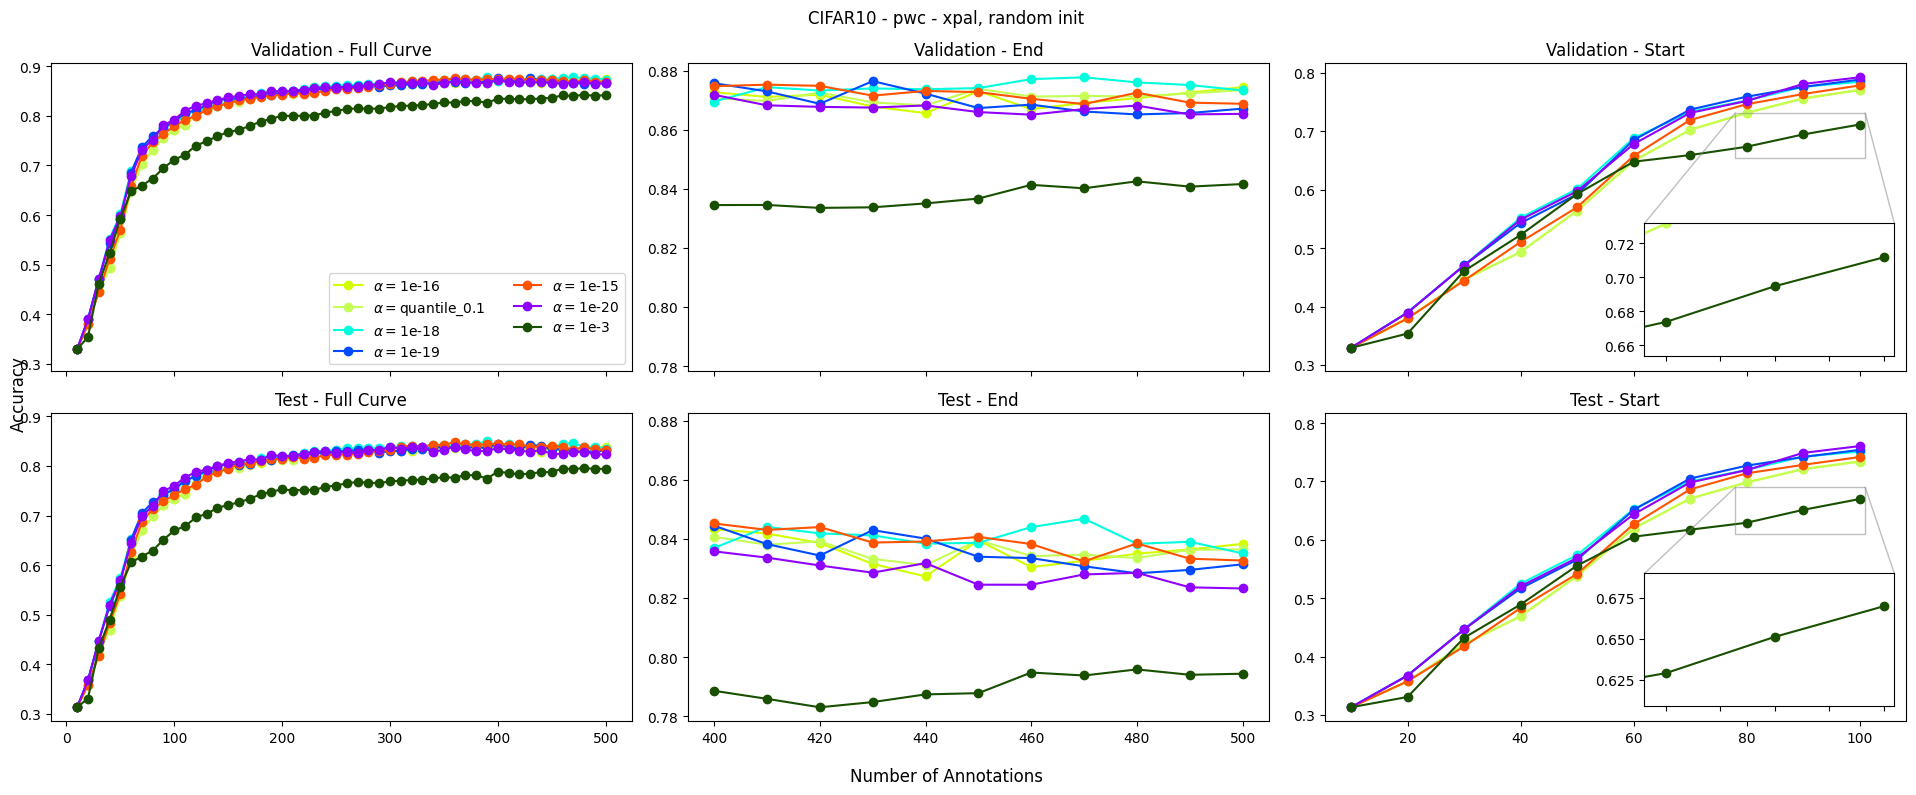

-- Performance INFO --
Max final validation accuracy: 0.874 reached with alpha=1e-16
Max final validation accuracy after 100 samples: 0.793 reached with alpha=1e-20
Max validation AUC: 0.809 reached with alpha=1e-18
Max early validation AUC: 0.608 reached with alpha=1e-18

-- ALPHA - INFO --
$\alpha=$1e-16 -> 1.000e-16 (± 1.23e-32)
$\alpha=$1e-18 -> 1.000e-18 (± 0.00e+00)
$\alpha=$1e-20 -> 1.000e-20 (± 0.00e+00)


In [30]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.Random.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

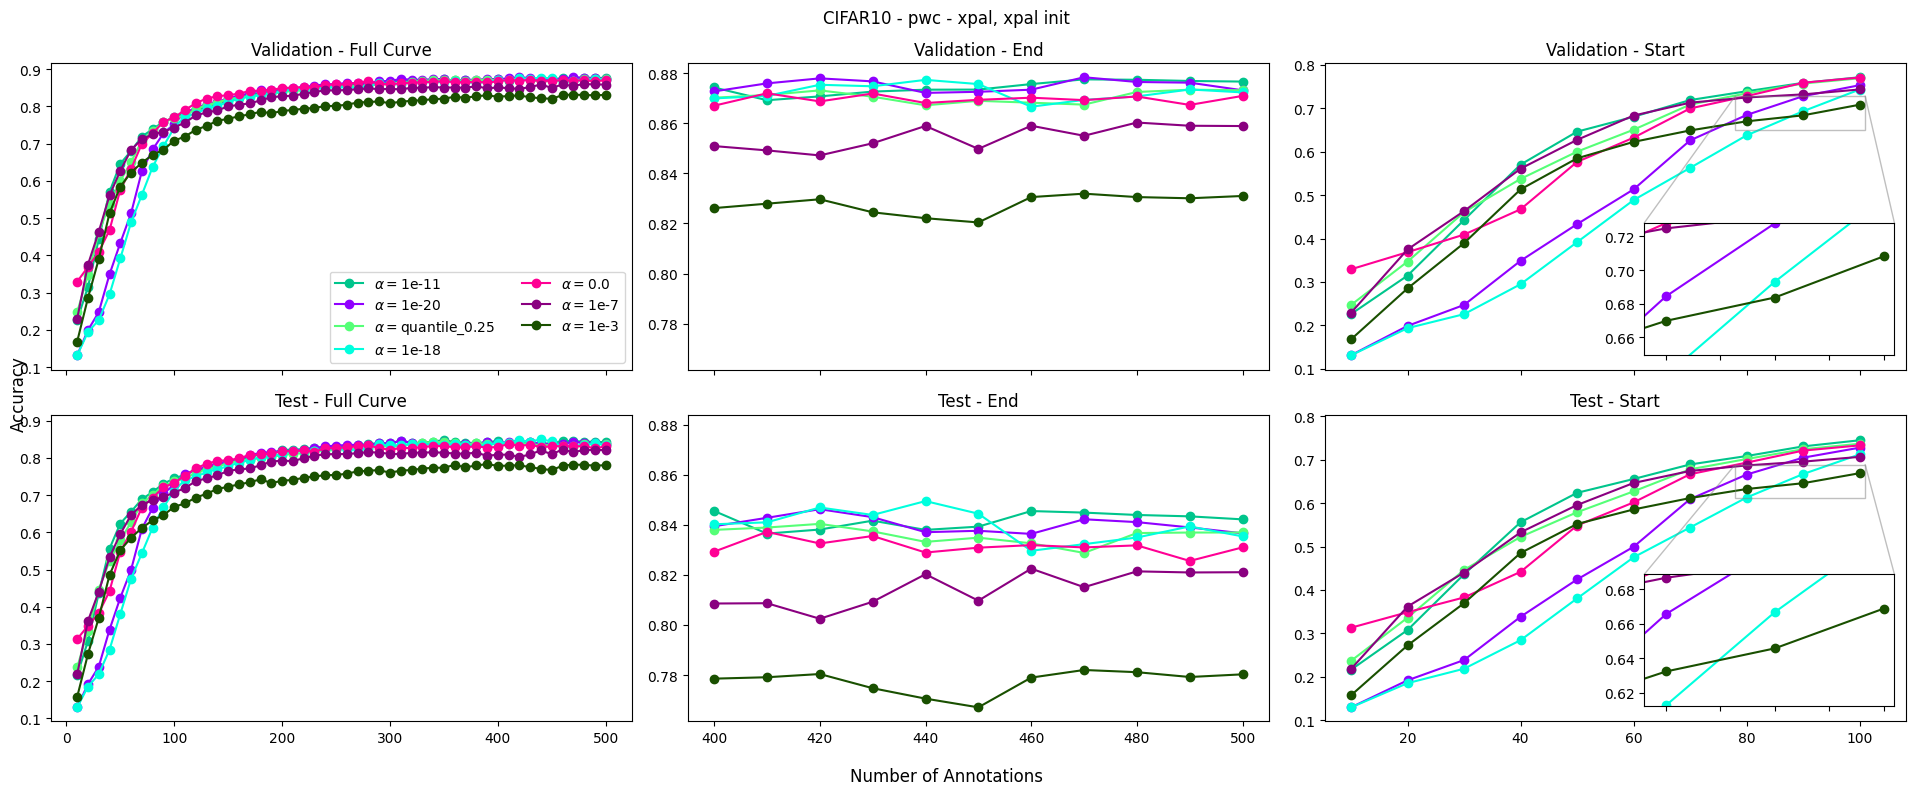

-- Performance INFO --
Max final validation accuracy: 0.877 reached with alpha=1e-11
Max final validation accuracy after 100 samples: 0.776 reached with alpha=quantile_0.33
Max validation AUC: 0.801 reached with alpha=1e-11
Max early validation AUC: 0.587 reached with alpha=1e-11

-- ALPHA - INFO --
$\alpha=$1e-11 -> 1.000e-11 (± 0.00e+00)


In [31]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.XPAL.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

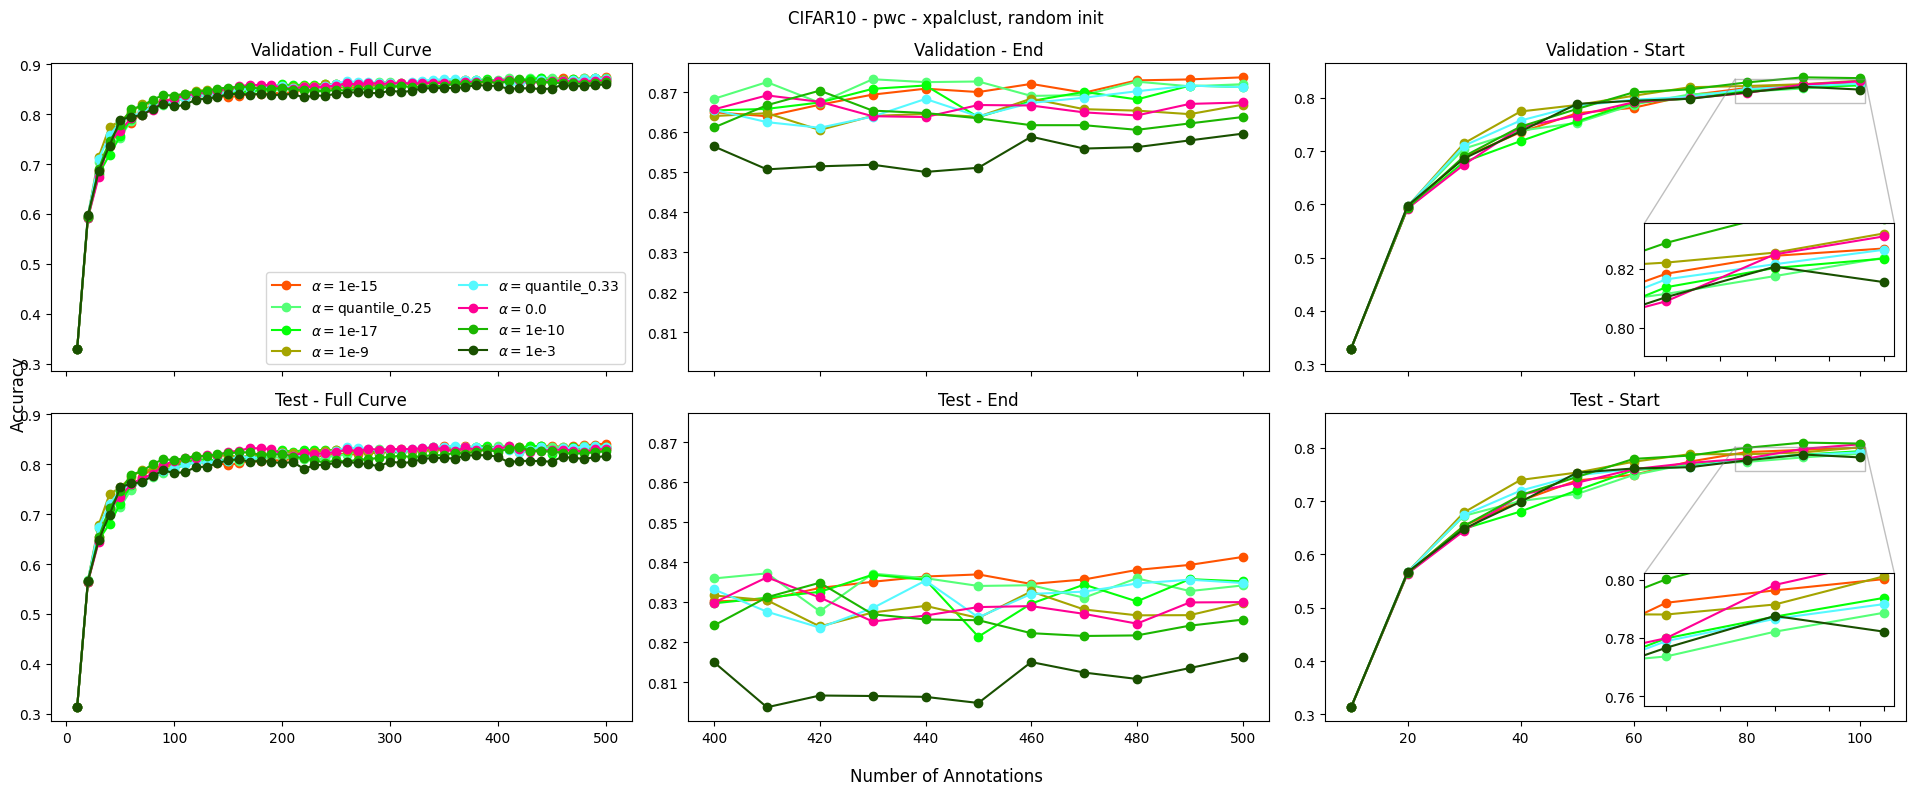

-- Performance INFO --
Max final validation accuracy: 0.874 reached with alpha=1e-15
Max final validation accuracy after 100 samples: 0.840 reached with alpha=1e-13
Max validation AUC: 0.833 reached with alpha=1e-9
Max early validation AUC: 0.730 reached with alpha=1e-9

-- ALPHA - INFO --
$\alpha=$1e-15 -> 1.000e-15 (± 0.00e+00)
$\alpha=$1e-9 -> 1.000e-09 (± 0.00e+00)


In [32]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.Random.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

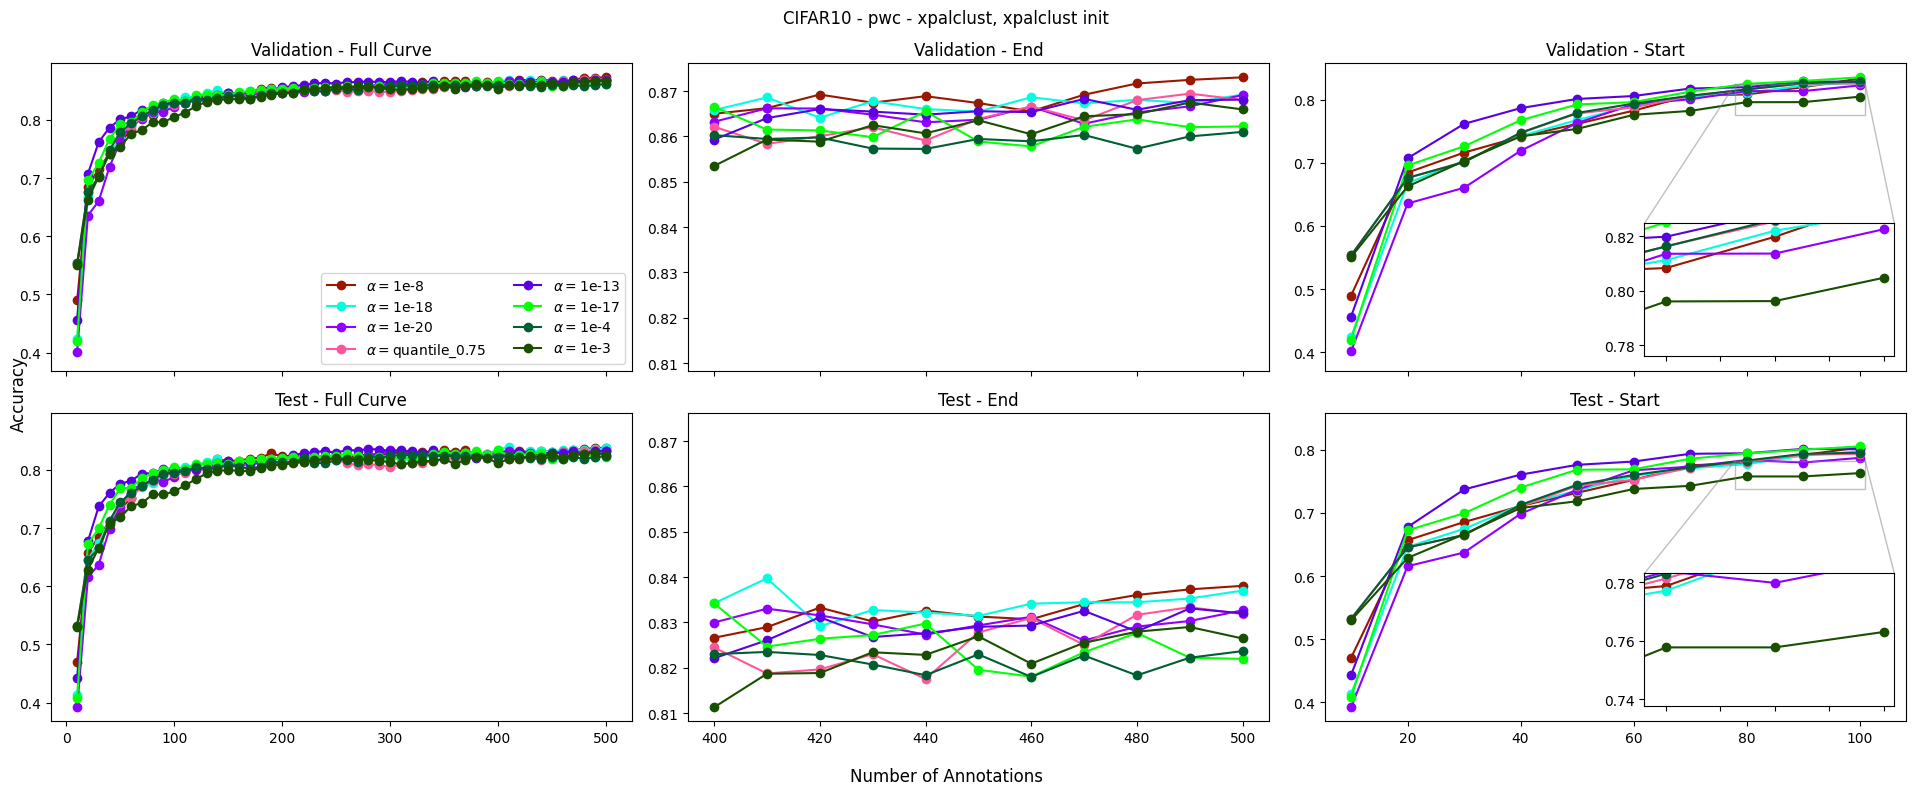

-- Performance INFO --
Max final validation accuracy: 0.873 reached with alpha=1e-8
Max final validation accuracy after 100 samples: 0.835 reached with alpha=1e-17
Max validation AUC: 0.839 reached with alpha=1e-13
Max early validation AUC: 0.761 reached with alpha=1e-13

-- ALPHA - INFO --
$\alpha=$1e-8 -> 1.000e-08 (± 0.00e+00)
$\alpha=$1e-13 -> 1.000e-13 (± 0.00e+00)
$\alpha=$1e-17 -> 1.000e-17 (± 0.00e+00)


In [33]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.XPALClust.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

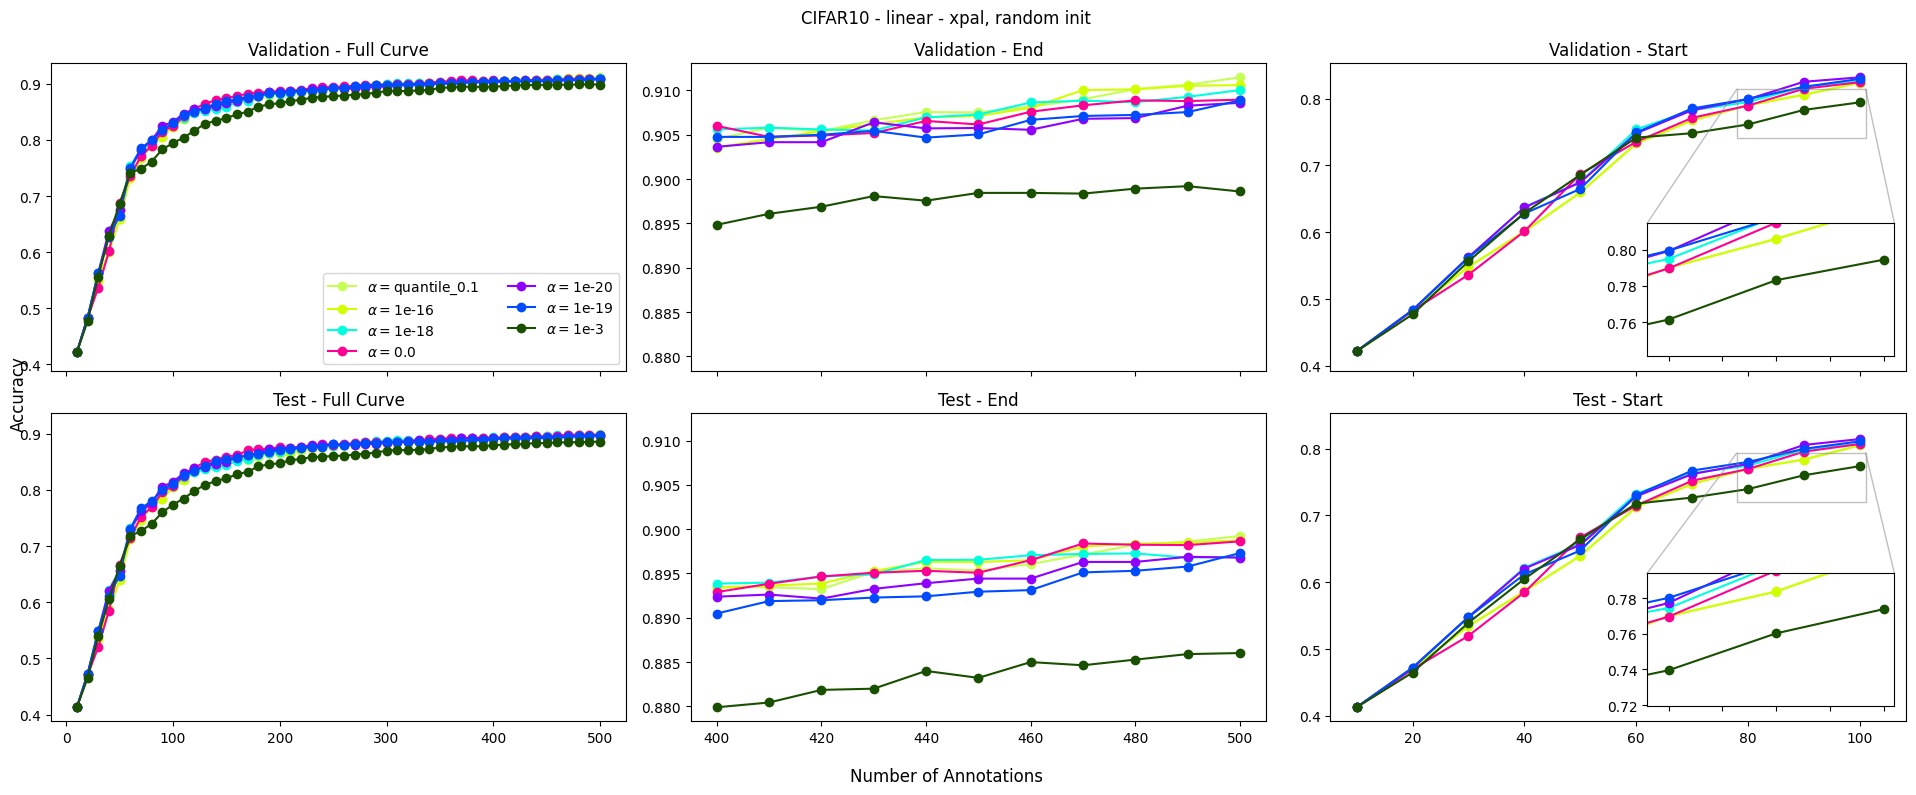

-- Performance INFO --
Max final validation accuracy: 0.911 reached with alpha=quantile_0.1
Max final validation accuracy after 100 samples: 0.832 reached with alpha=1e-20
Max validation AUC: 0.849 reached with alpha=0.0
Max early validation AUC: 0.677 reached with alpha=1e-20

-- ALPHA - INFO --
$\alpha=$quantile_0.1 -> 1.277e-16 (± 7.17e-18)
$\alpha=$0.0 -> 0.000e+00 (± 0.00e+00)
$\alpha=$1e-20 -> 1.000e-20 (± 0.00e+00)


In [34]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.Random.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

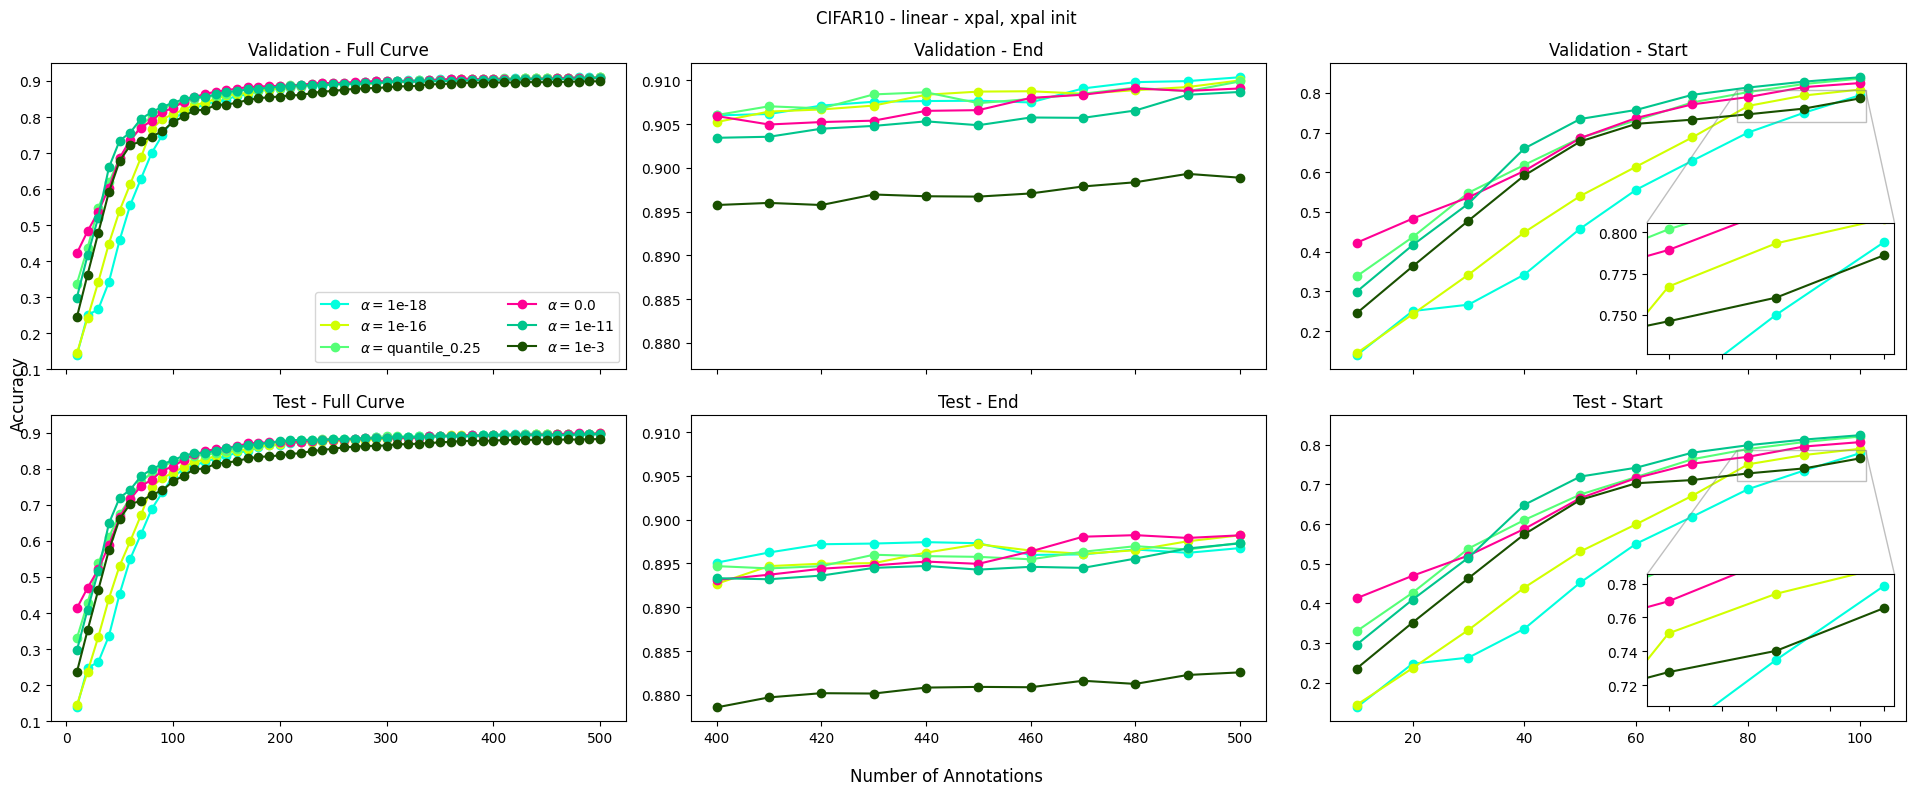

-- Performance INFO --
Max final validation accuracy: 0.910 reached with alpha=1e-18
Max final validation accuracy after 100 samples: 0.839 reached with alpha=1e-11
Max validation AUC: 0.849 reached with alpha=0.0
Max early validation AUC: 0.667 reached with alpha=0.0

-- ALPHA - INFO --
$\alpha=$1e-18 -> 1.000e-18 (± 0.00e+00)
$\alpha=$0.0 -> 0.000e+00 (± 0.00e+00)
$\alpha=$1e-11 -> 1.000e-11 (± 0.00e+00)


In [35]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.XPAL.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

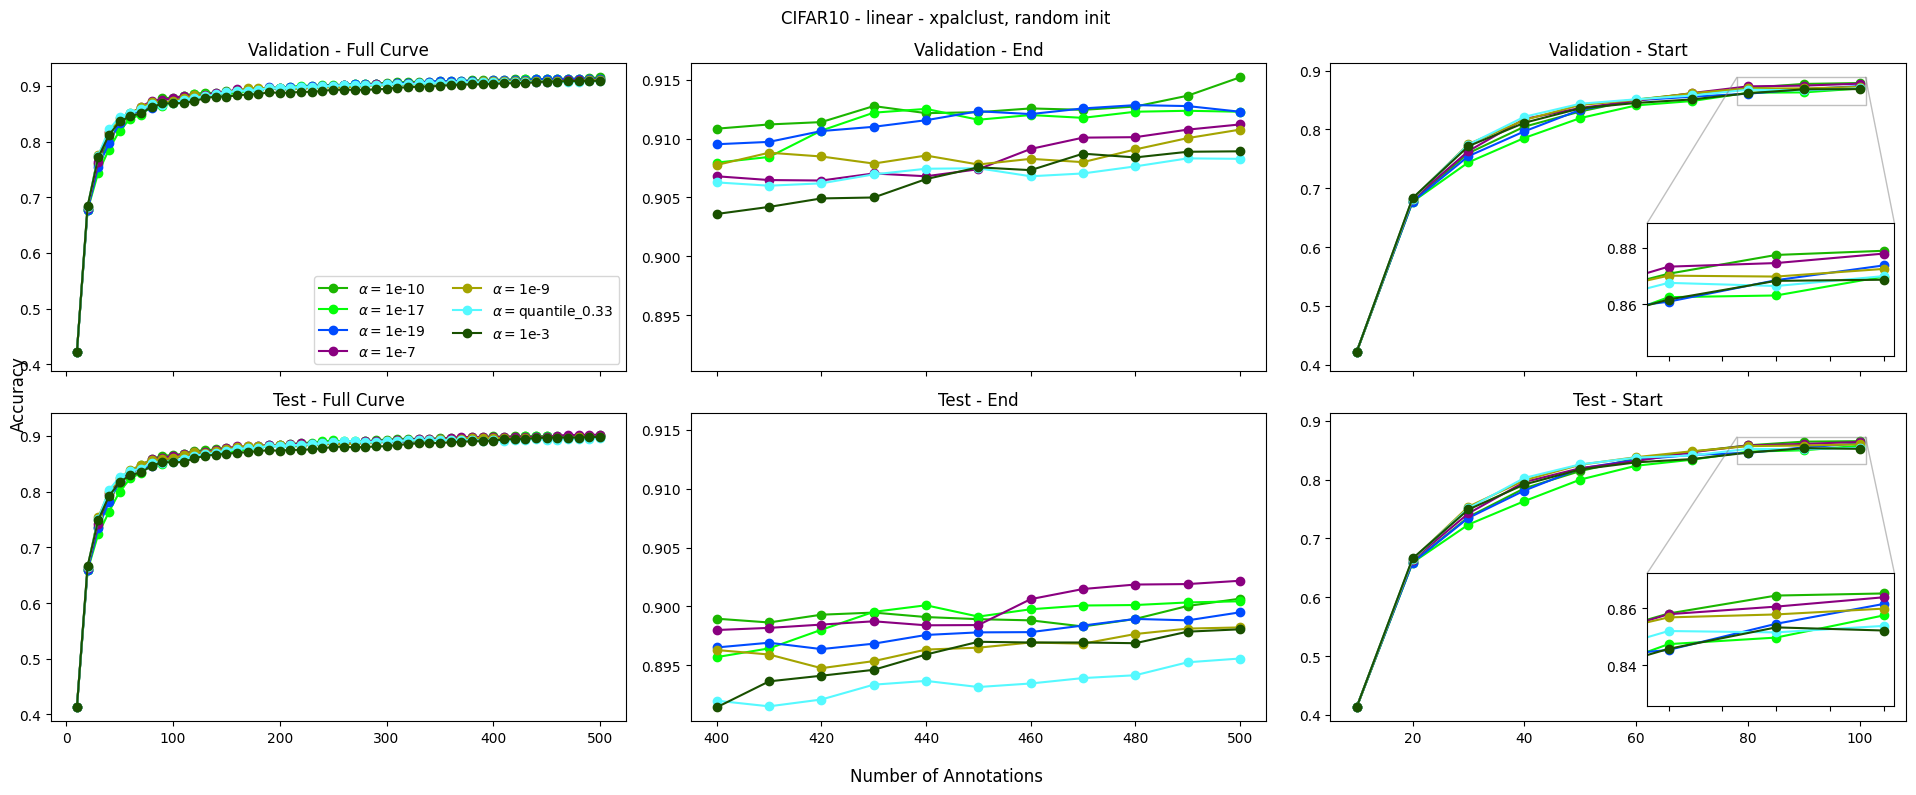

-- Performance INFO --
Max final validation accuracy: 0.915 reached with alpha=1e-10
Max final validation accuracy after 100 samples: 0.879 reached with alpha=1e-10
Max validation AUC: 0.879 reached with alpha=1e-10
Max early validation AUC: 0.786 reached with alpha=1e-9

-- ALPHA - INFO --
$\alpha=$1e-10 -> 1.000e-10 (± 0.00e+00)


In [36]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.Random.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

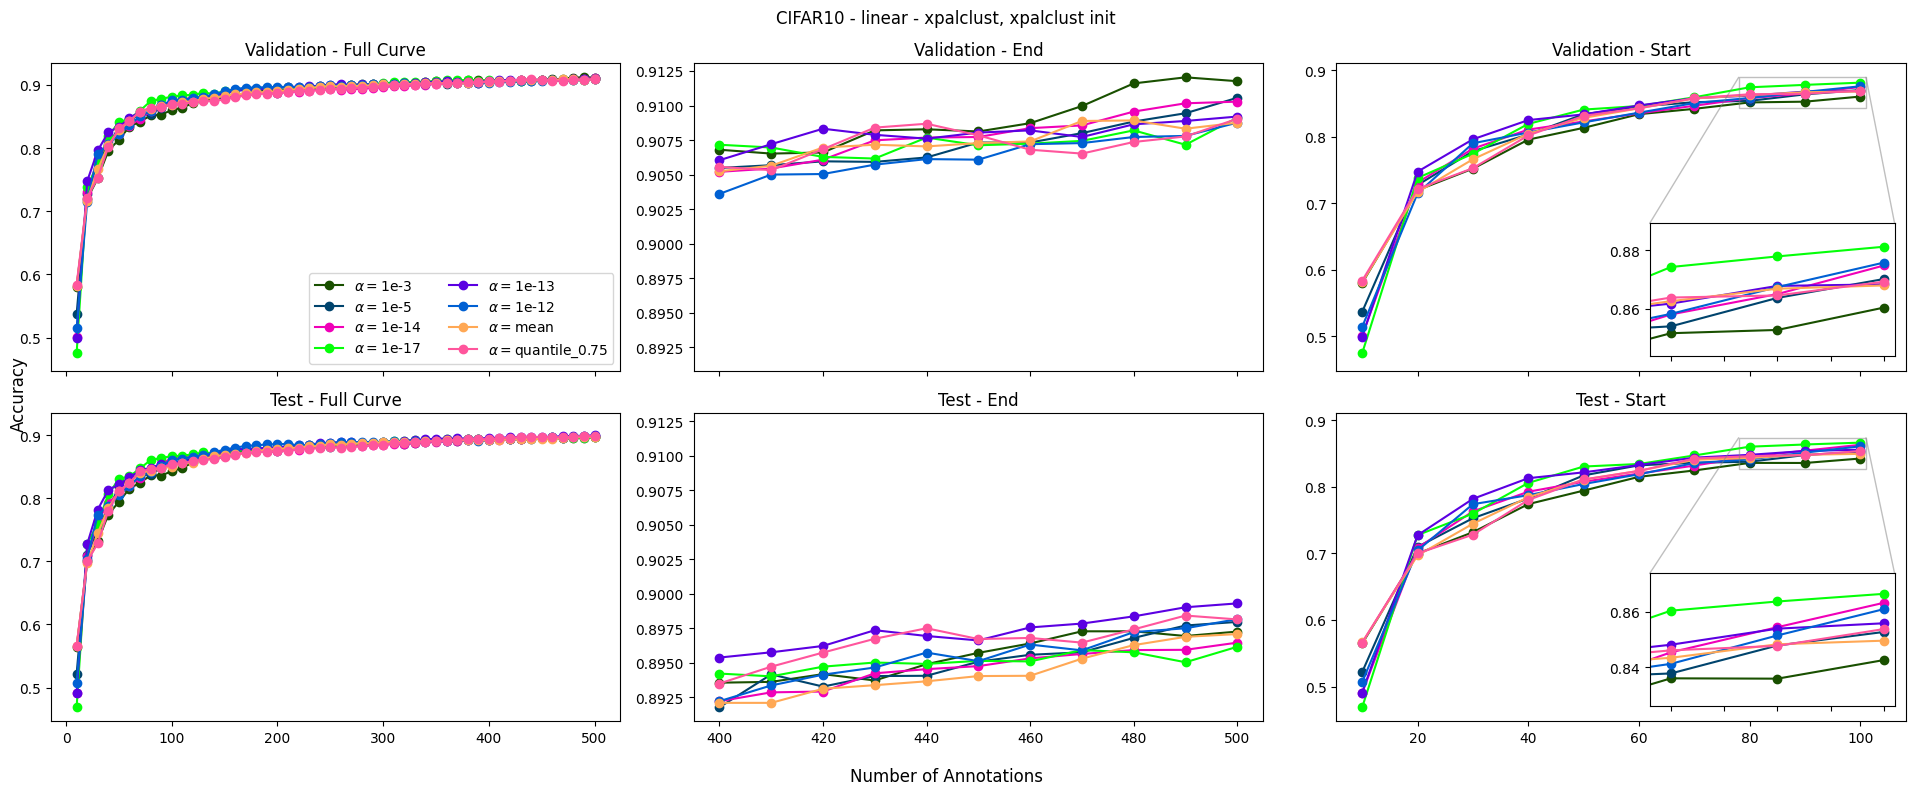

-- Performance INFO --
Max final validation accuracy: 0.912 reached with alpha=1e-3
Max final validation accuracy after 100 samples: 0.881 reached with alpha=1e-17
Max validation AUC: 0.880 reached with alpha=1e-17
Max early validation AUC: 0.800 reached with alpha=1e-13

-- ALPHA - INFO --
$\alpha=$1e-3 -> 1.000e-03 (± 0.00e+00)
$\alpha=$1e-17 -> 1.000e-17 (± 0.00e+00)


In [37]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.XPALClust.value, n_init=10, acq_size=10, n_acq=49, kernel="rbf", gamma="calculate", force_alpha="1e-3")

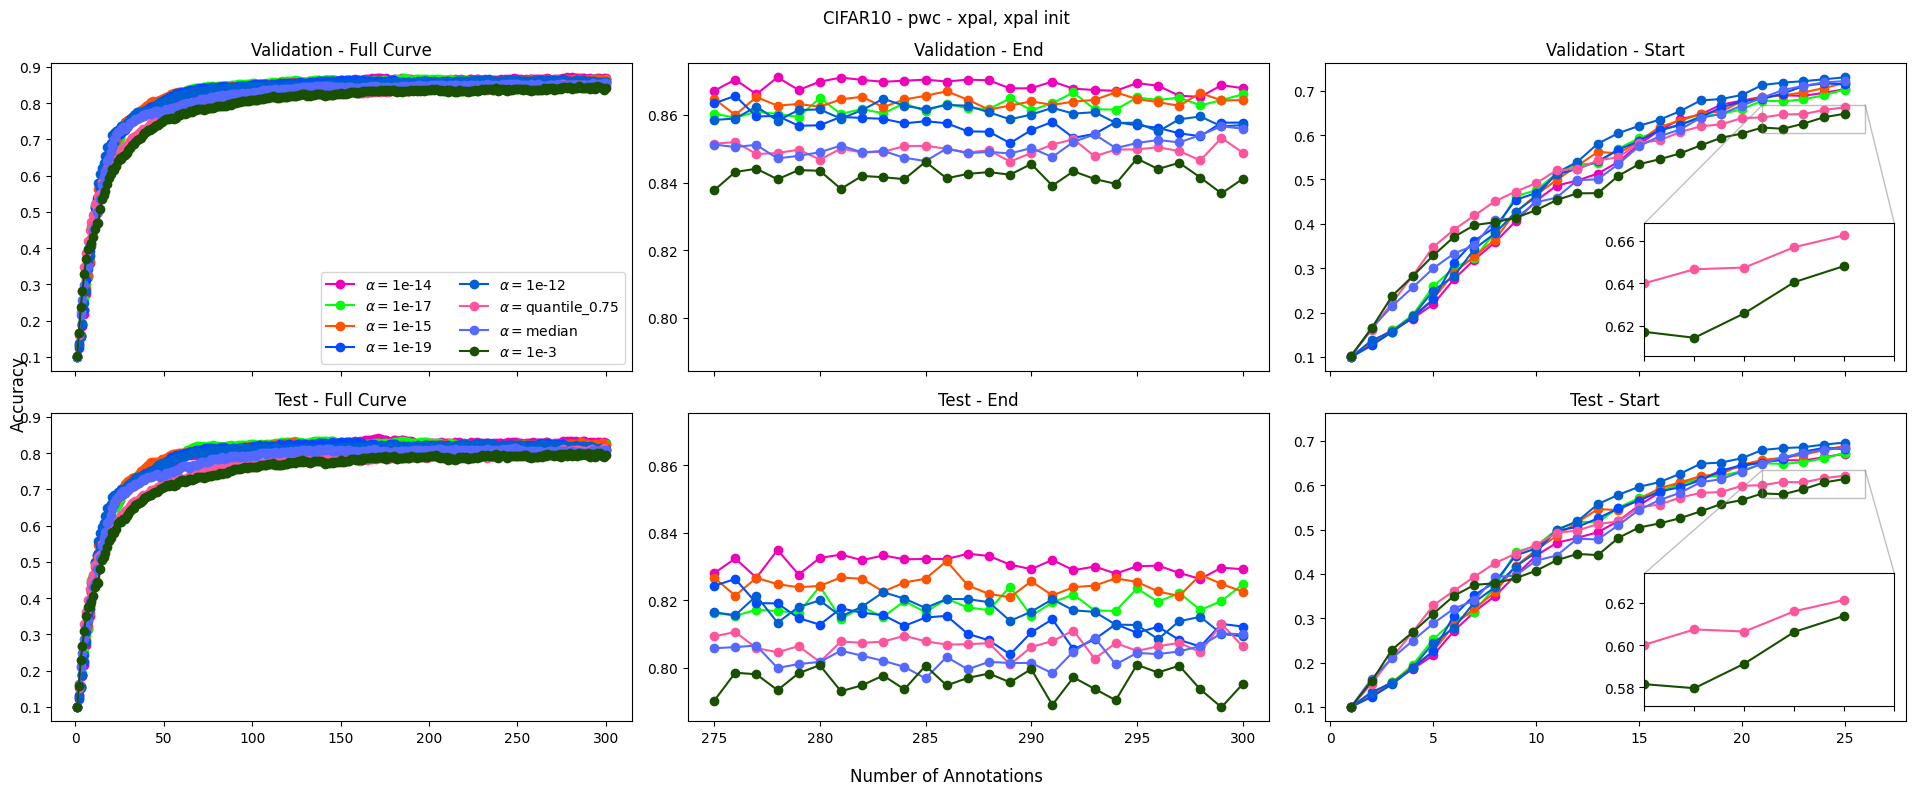

-- Performance INFO --
Max final validation accuracy: 0.868 reached with alpha=1e-14
Max final validation accuracy after 100 samples: 0.854 reached with alpha=1e-17
Max validation AUC: 0.819 reached with alpha=1e-17
Max early validation AUC: 0.501 reached with alpha=1e-12

-- ALPHA - INFO --
$\alpha=$1e-14 -> 1.000e-14 (± 0.00e+00)
$\alpha=$1e-17 -> 1.000e-17 (± 0.00e+00)


In [38]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.XPAL.value, n_init=1, acq_size=1, n_acq=299, kernel="rbf", gamma="calculate", force_alpha="1e-3")

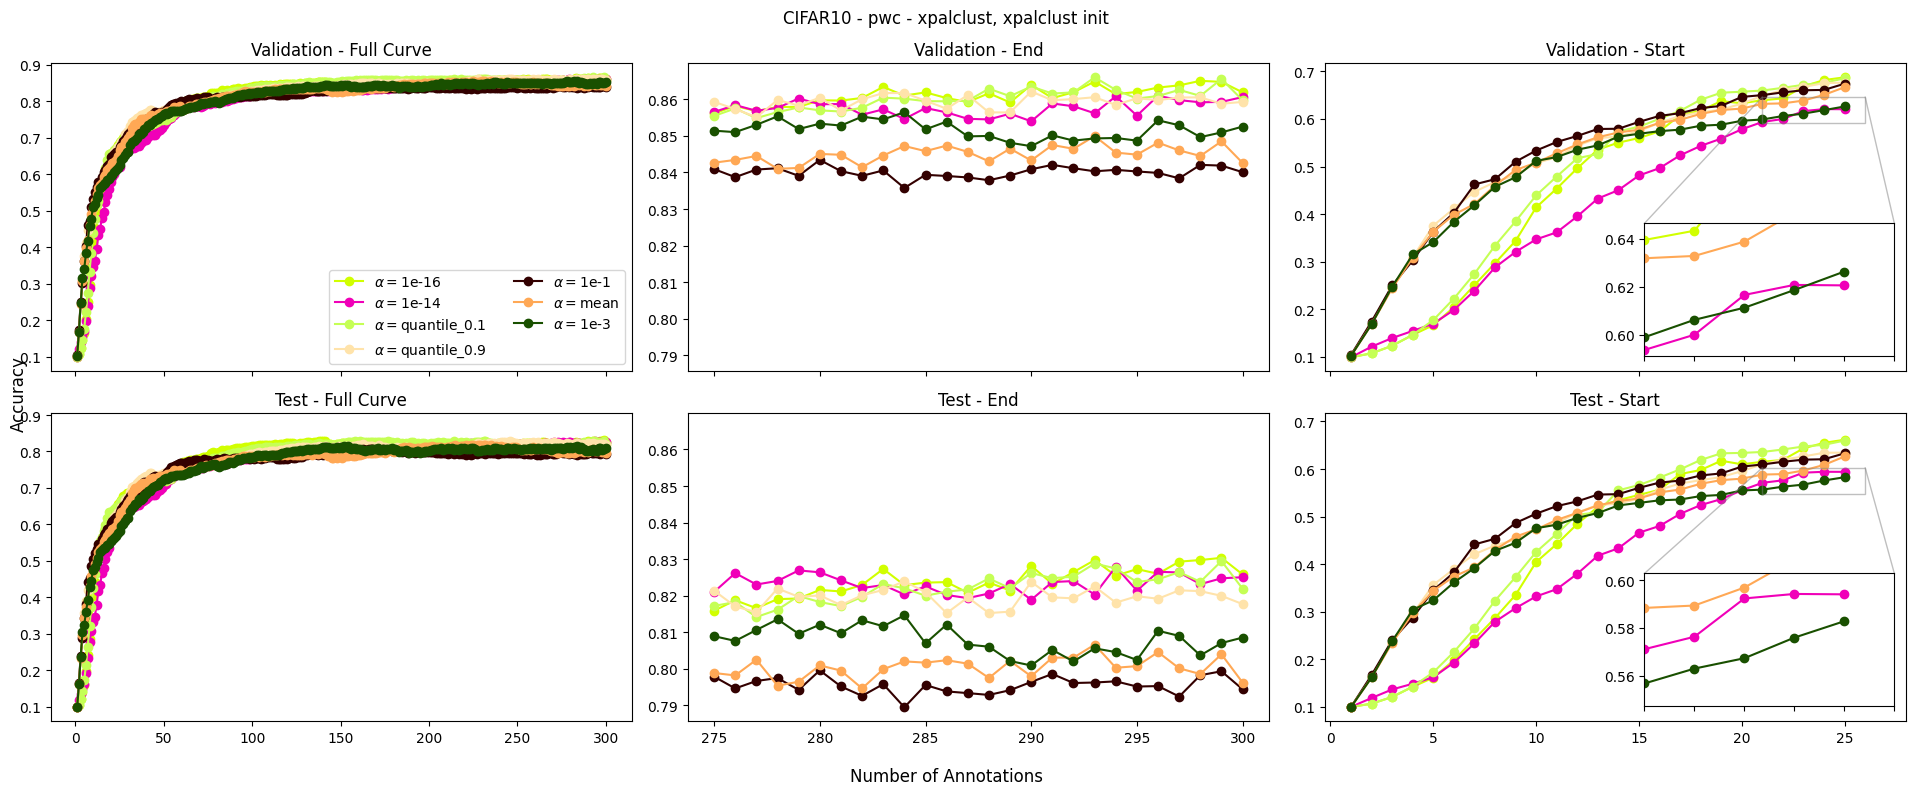

-- Performance INFO --
Max final validation accuracy: 0.862 reached with alpha=1e-16
Max final validation accuracy after 100 samples: 0.841 reached with alpha=1e-16
Max validation AUC: 0.805 reached with alpha=quantile_0.9
Max early validation AUC: 0.514 reached with alpha=1e-1

-- ALPHA - INFO --
$\alpha=$1e-16 -> 1.000e-16 (± 1.23e-32)
$\alpha=$quantile_0.9 -> 2.182e-03 (± 1.62e-05)


In [39]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.PWC.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.XPALClust.value, n_init=1, acq_size=1, n_acq=299, kernel="rbf", gamma="calculate", force_alpha="1e-3")

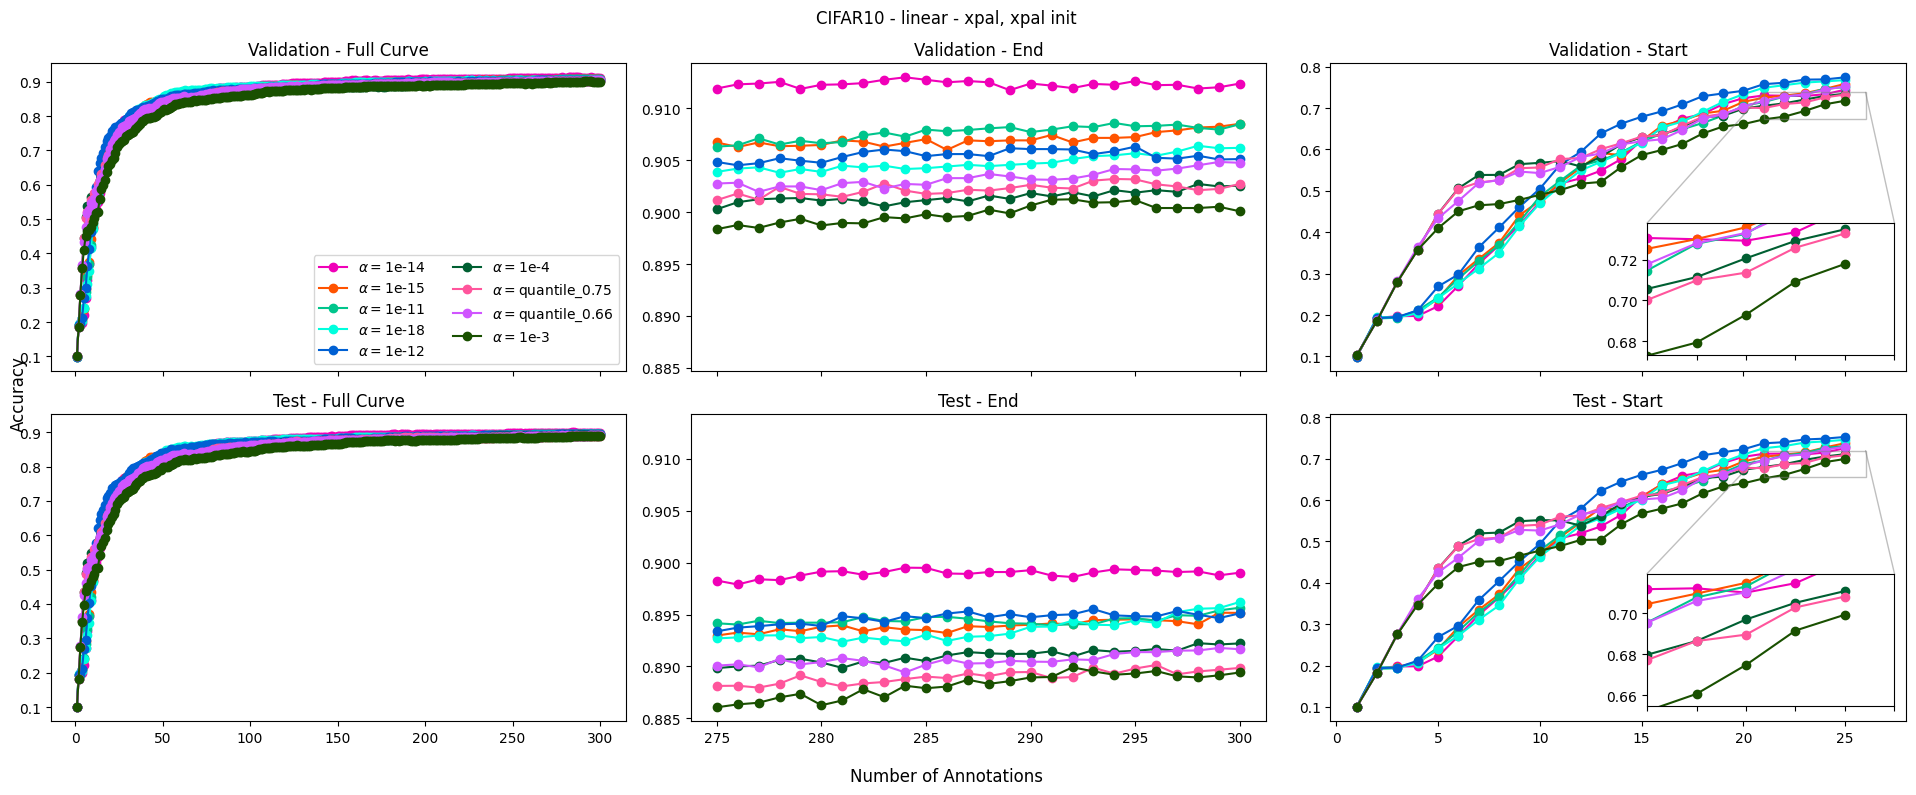

-- Performance INFO --
Max final validation accuracy: 0.912 reached with alpha=1e-14
Max final validation accuracy after 100 samples: 0.888 reached with alpha=0.0
Max validation AUC: 0.858 reached with alpha=1e-14
Max early validation AUC: 0.560 reached with alpha=1e-4

-- ALPHA - INFO --
$\alpha=$1e-14 -> 1.000e-14 (± 0.00e+00)


In [40]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPAL.value, init_strategy=Strategy.XPAL.value, n_init=1, acq_size=1, n_acq=299, kernel="rbf", gamma="calculate", force_alpha="1e-3")

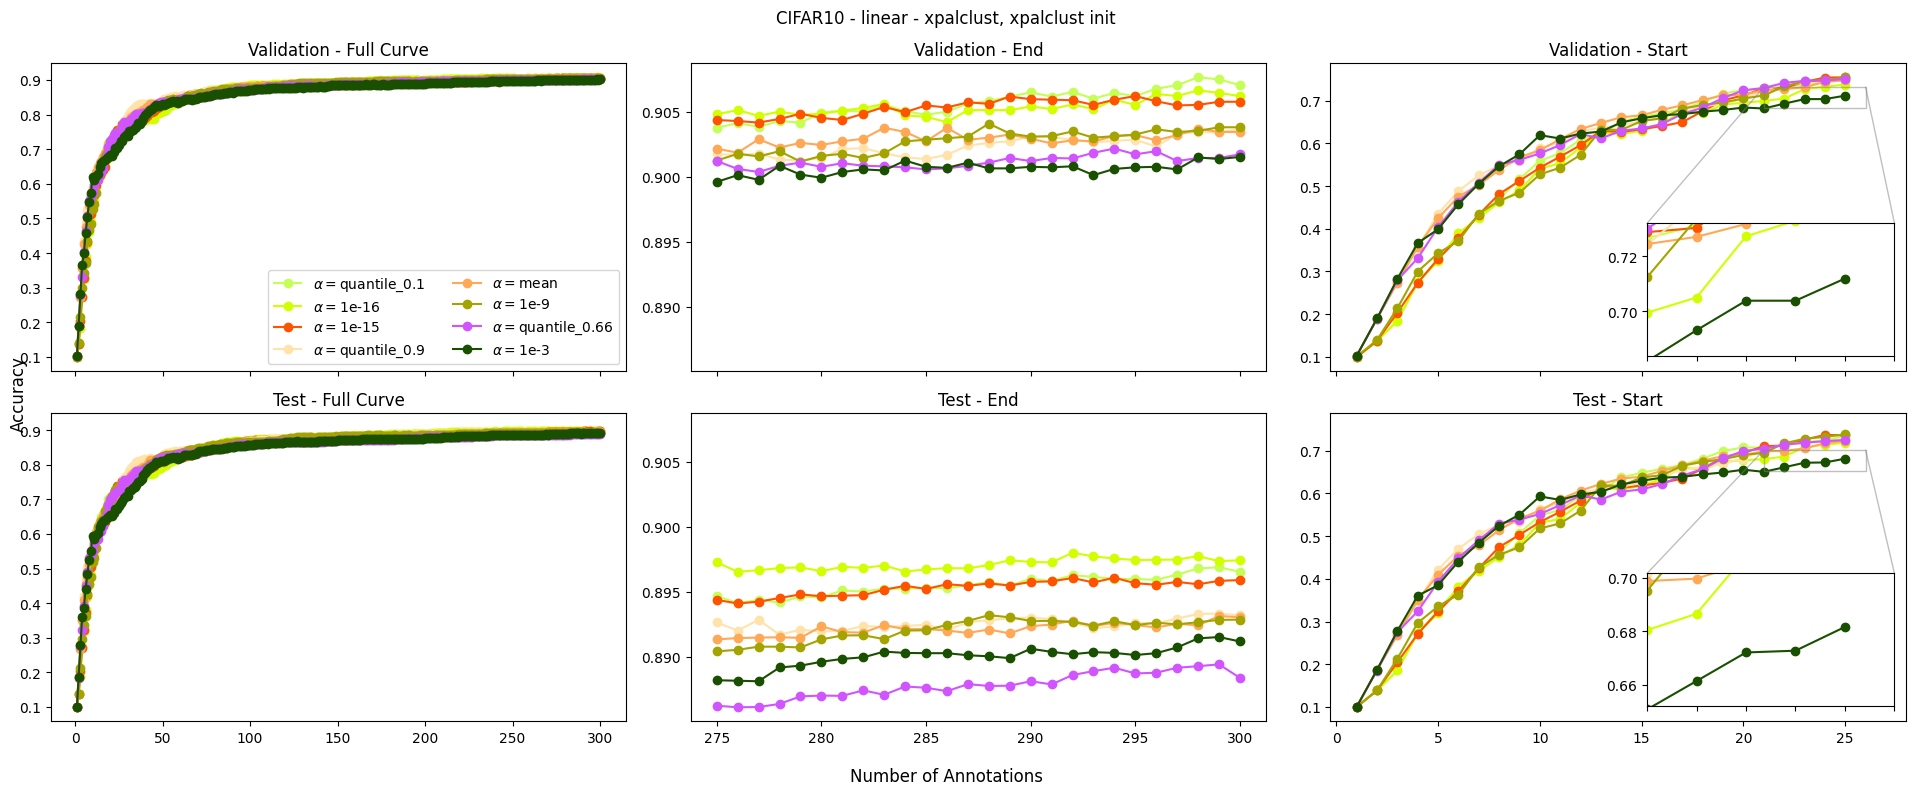

-- Performance INFO --
Max final validation accuracy: 0.907 reached with alpha=quantile_0.1
Max final validation accuracy after 100 samples: 0.885 reached with alpha=1e-16
Max validation AUC: 0.856 reached with alpha=quantile_0.9
Max early validation AUC: 0.576 reached with alpha=mean

-- ALPHA - INFO --
$\alpha=$quantile_0.1 -> 1.277e-16 (± 7.17e-18)
$\alpha=$1e-16 -> 1.000e-16 (± 1.23e-32)
$\alpha=$quantile_0.9 -> 2.182e-03 (± 1.62e-05)


In [41]:
evaluate_experiments(dataset=Dataset.CIFAR10.value, model=Model.Linear.value, al_strategy=Strategy.XPALClust.value, init_strategy=Strategy.XPALClust.value, n_init=1, acq_size=1, n_acq=299, kernel="rbf", gamma="calculate", force_alpha="1e-3")

In [8]:
# Not used, use optimal for every test

def rank_alphas(datasets, models, strategies, al_settings, kernel="rbf", gamma="calculate"):
    final_rankings = {alpha : 0 for alpha in xpal_alphas}
    max_rankings = {alpha : 0 for alpha in xpal_alphas}
    auc_rankings = {alpha : 0 for alpha in xpal_alphas}
    early_auc_rankings = {alpha : 0 for alpha in xpal_alphas}

    lp = list(itertools.product(datasets, models, strategies, al_settings))
    num_exps = len(lp)

    for dataset, model, strategy, al_setting in tqdm(lp):
        experiments = {"$\\alpha=$" + alpha:xpal_hparams_path(dataset=dataset, model=model, al_strategy=strategy[0], init_strategy=strategy[1], alpha=alpha, n_init=al_setting[0], acq_size=al_setting[1], n_acq=al_setting[2], kernel=kernel, gamma=gamma) for alpha in xpal_alphas}
        if strategy[1] == "random" and al_setting[1] == 1:
            continue

        validation_curves = generate_learning_curves(experiments, "validation_stats")
    
        best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: x[1]["acc"][-1], reverse=True) # Final
        xpal_best_alphas = [key.split('$')[-1] for key, _ in best_hparams_learning_curves]

        for idx, alpha in enumerate(xpal_best_alphas):
            final_rankings[alpha] += (idx + 1)

        best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.max(x[1]["acc"]), reverse=True) # Max
        xpal_best_alphas = [key.split('$')[-1] for key, _ in best_hparams_learning_curves]

        for idx, alpha in enumerate(xpal_best_alphas):
            max_rankings[alpha] += (idx + 1)
    
        best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.mean(x[1]["acc"]), reverse=True) # AUC
        xpal_best_alphas = [key.split('$')[-1] for key, _ in best_hparams_learning_curves]

        for idx, alpha in enumerate(xpal_best_alphas):
            auc_rankings[alpha] += (idx + 1)

        until = 25 if strategy[1] == 1 else 10
        best_hparams_learning_curves = sorted(validation_curves.items(), key=lambda x: np.mean(x[1]["acc"][:until]), reverse=True) # Low Budget AUC
        xpal_best_alphas = [key.split('$')[-1] for key, _ in best_hparams_learning_curves]

        for idx, alpha in enumerate(xpal_best_alphas):
            early_auc_rankings[alpha] += (idx + 1)


    final_rankings = {k: v / num_exps for k, v in sorted(final_rankings.items(), key=lambda item: item[1])}
    max_rankings = {k: v /num_exps for k, v in sorted(max_rankings.items(), key=lambda item: item[1])}
    auc_rankings = {k: v /num_exps for k, v in sorted(auc_rankings.items(), key=lambda item: item[1])}
    early_auc_rankings = {k: v /num_exps for k, v in sorted(early_auc_rankings.items(), key=lambda item: item[1])}
    
    return final_rankings, max_rankings, auc_rankings, early_auc_rankings

In [9]:
d = ["CIFAR10"]
m = ["pwc", "linear"]
s = [("xpal", "random"), ("xpal", "xpal"), ("xpalclust", "random"), ("xpalclust", "xpalclust")]
al = [(10, 10, 49), (1, 1, 299)]
rank_alphas(d, m, s, al)

100%|██████████| 16/16 [14:03<00:00, 52.72s/it]


({'quantile_0.1': 3.125,
  '1e-15': 3.875,
  '1e-17': 4.5625,
  '1e-13': 4.625,
  '1e-11': 4.8125,
  'quantile_0.33': 5.125,
  'quantile_0.25': 5.9375,
  '0.0': 6.3125,
  '1e-7': 6.75,
  '1e-9': 6.875,
  'median': 7.1875,
  '1e-5': 7.875,
  '1e-3': 9.0,
  'quantile_0.66': 9.125,
  'quantile_0.75': 9.5625,
  'quantile_0.9': 9.75,
  'mean': 10.9375,
  '1e-1': 12.8125},
 {'quantile_0.1': 3.375,
  '1e-15': 3.6875,
  '1e-13': 4.5,
  '1e-17': 5.0,
  '1e-11': 5.0625,
  'quantile_0.33': 5.4375,
  'quantile_0.25': 5.5,
  '0.0': 6.125,
  '1e-9': 6.75,
  '1e-7': 6.8125,
  'median': 7.6875,
  '1e-5': 7.8125,
  'quantile_0.66': 9.0625,
  '1e-3': 9.25,
  'quantile_0.75': 9.25,
  'quantile_0.9': 9.75,
  'mean': 10.5625,
  '1e-1': 12.625},
 {'1e-17': 3.9375,
  '1e-15': 4.25,
  'quantile_0.33': 4.6875,
  '1e-9': 4.8125,
  'quantile_0.1': 5.125,
  '0.0': 5.5,
  '1e-13': 5.8125,
  'quantile_0.25': 6.1875,
  '1e-11': 6.875,
  '1e-7': 6.9375,
  'median': 7.375,
  'quantile_0.66': 7.625,
  'mean': 8.875,
  

In [10]:
d = ["CIFAR10"]
m = ["pwc"]
s = [("xpal", "random"), ("xpal", "xpal"), ("xpalclust", "random"), ("xpalclust", "xpalclust")]
al = [(10, 10, 49), (1, 1, 299)]
rank_alphas(d, m, s, al)

100%|██████████| 8/8 [06:41<00:00, 50.18s/it]


({'quantile_0.1': 3.375,
  '1e-15': 3.625,
  '1e-17': 3.75,
  'quantile_0.25': 3.75,
  'quantile_0.33': 4.125,
  '1e-13': 4.5,
  '1e-11': 5.0,
  '0.0': 6.25,
  '1e-7': 6.625,
  '1e-9': 7.0,
  '1e-5': 8.5,
  'median': 8.625,
  '1e-3': 9.375,
  'quantile_0.66': 9.375,
  'quantile_0.75': 9.375,
  'quantile_0.9': 10.0,
  'mean': 11.5,
  '1e-1': 13.5},
 {'quantile_0.25': 3.0,
  '1e-15': 3.125,
  'quantile_0.1': 3.875,
  '1e-13': 4.25,
  '1e-17': 4.375,
  'quantile_0.33': 4.75,
  '0.0': 5.75,
  '1e-11': 5.875,
  '1e-7': 6.75,
  '1e-9': 6.75,
  '1e-5': 8.375,
  'quantile_0.75': 8.75,
  'quantile_0.66': 9.25,
  'median': 9.625,
  '1e-3': 9.75,
  'quantile_0.9': 9.875,
  'mean': 11.0,
  '1e-1': 13.125},
 {'1e-15': 3.5,
  '1e-17': 3.5,
  'quantile_0.1': 4.125,
  '1e-13': 4.625,
  'quantile_0.33': 4.75,
  '0.0': 4.875,
  'quantile_0.25': 4.875,
  '1e-9': 5.0,
  '1e-11': 7.0,
  '1e-7': 7.75,
  'median': 8.25,
  'quantile_0.66': 8.25,
  '1e-5': 9.5,
  'mean': 9.5,
  'quantile_0.75': 9.625,
  'quant

In [11]:
d = ["CIFAR10"]
m = ["linear"]
s = [("xpal", "random"), ("xpal", "xpal"), ("xpalclust", "random"), ("xpalclust", "xpalclust")]
al = [(10, 10, 49), (1, 1, 299)]
rank_alphas(d, m, s, al)

100%|██████████| 8/8 [06:48<00:00, 51.00s/it]


({'quantile_0.1': 2.875,
  '1e-15': 4.125,
  '1e-11': 4.625,
  '1e-13': 4.75,
  '1e-17': 5.375,
  'median': 5.75,
  'quantile_0.33': 6.125,
  '0.0': 6.375,
  '1e-9': 6.75,
  '1e-7': 6.875,
  '1e-5': 7.25,
  'quantile_0.25': 8.125,
  '1e-3': 8.625,
  'quantile_0.66': 8.875,
  'quantile_0.9': 9.5,
  'quantile_0.75': 9.75,
  'mean': 10.375,
  '1e-1': 12.125},
 {'quantile_0.1': 2.875,
  '1e-11': 4.25,
  '1e-15': 4.25,
  '1e-13': 4.75,
  '1e-17': 5.625,
  'median': 5.75,
  'quantile_0.33': 6.125,
  '0.0': 6.5,
  '1e-9': 6.75,
  '1e-7': 6.875,
  '1e-5': 7.25,
  'quantile_0.25': 8.0,
  '1e-3': 8.75,
  'quantile_0.66': 8.875,
  'quantile_0.9': 9.625,
  'quantile_0.75': 9.75,
  'mean': 10.125,
  '1e-1': 12.125},
 {'1e-17': 4.375,
  '1e-9': 4.625,
  'quantile_0.33': 4.625,
  '1e-15': 5.0,
  '1e-7': 6.125,
  '0.0': 6.125,
  'quantile_0.1': 6.125,
  'median': 6.5,
  '1e-11': 6.75,
  '1e-13': 7.0,
  'quantile_0.66': 7.0,
  'quantile_0.25': 7.5,
  'mean': 8.25,
  'quantile_0.9': 8.25,
  '1e-5': 8.75

In [12]:
d = ["CIFAR10"]
m = ["pwc", "linear"]
s = [("xpal", "random"), ("xpal", "xpal")]
al = [(10, 10, 49), (1, 1, 299)]
rank_alphas(d, m, s, al)

100%|██████████| 8/8 [06:36<00:00, 49.59s/it]


({'1e-11': 2.375,
  '1e-15': 3.0,
  'quantile_0.1': 3.125,
  '0.0': 3.5,
  '1e-17': 4.25,
  'quantile_0.25': 4.25,
  'quantile_0.33': 4.625,
  '1e-13': 5.125,
  '1e-7': 6.5,
  '1e-9': 7.0,
  'median': 7.125,
  'quantile_0.66': 7.75,
  '1e-5': 10.125,
  'quantile_0.75': 10.125,
  '1e-3': 11.625,
  'mean': 11.625,
  'quantile_0.9': 12.75,
  '1e-1': 13.375},
 {'1e-15': 2.625,
  '1e-11': 2.875,
  'quantile_0.25': 3.125,
  'quantile_0.1': 3.375,
  '0.0': 3.5,
  'quantile_0.33': 4.75,
  '1e-13': 4.875,
  '1e-17': 4.875,
  '1e-7': 6.0,
  '1e-9': 6.875,
  'median': 7.5,
  'quantile_0.66': 8.25,
  'quantile_0.75': 10.0,
  '1e-5': 10.25,
  '1e-3': 11.5,
  'mean': 11.75,
  'quantile_0.9': 12.75,
  '1e-1': 13.375},
 {'0.0': 3.75,
  '1e-15': 4.375,
  'quantile_0.1': 4.375,
  'quantile_0.25': 4.375,
  '1e-11': 4.5,
  '1e-17': 4.5,
  'quantile_0.33': 5.25,
  '1e-7': 5.375,
  '1e-13': 5.375,
  '1e-9': 5.5,
  'median': 6.75,
  'quantile_0.66': 8.5,
  'quantile_0.75': 9.0,
  '1e-5': 9.875,
  '1e-3': 10.

In [13]:
d = ["CIFAR10"]
m = ["pwc", "linear"]
s = [("xpalclust", "random"), ("xpalclust", "xpalclust")]
al = [(10, 10, 49), (1, 1, 299)]
rank_alphas(d, m, s, al)

100%|██████████| 8/8 [06:36<00:00, 49.56s/it]


({'quantile_0.1': 3.125,
  '1e-13': 4.125,
  '1e-15': 4.75,
  '1e-17': 4.875,
  '1e-5': 5.625,
  'quantile_0.33': 5.625,
  '1e-3': 6.375,
  '1e-9': 6.75,
  'quantile_0.9': 6.75,
  '1e-7': 7.0,
  '1e-11': 7.25,
  'median': 7.25,
  'quantile_0.25': 7.625,
  'quantile_0.75': 9.0,
  '0.0': 9.125,
  'mean': 10.25,
  'quantile_0.66': 10.5,
  '1e-1': 12.25},
 {'quantile_0.1': 3.375,
  '1e-13': 4.125,
  '1e-15': 4.75,
  '1e-17': 5.125,
  '1e-5': 5.375,
  'quantile_0.33': 6.125,
  '1e-9': 6.625,
  'quantile_0.9': 6.75,
  '1e-3': 7.0,
  '1e-11': 7.25,
  '1e-7': 7.625,
  'quantile_0.25': 7.875,
  'median': 7.875,
  'quantile_0.75': 8.5,
  '0.0': 8.75,
  'mean': 9.375,
  'quantile_0.66': 9.875,
  '1e-1': 11.875},
 {'1e-17': 3.375,
  '1e-9': 4.125,
  '1e-15': 4.125,
  'quantile_0.33': 4.125,
  'quantile_0.1': 5.875,
  '1e-13': 6.25,
  'mean': 6.5,
  'quantile_0.9': 6.5,
  'quantile_0.66': 6.75,
  '0.0': 7.25,
  'quantile_0.25': 8.0,
  'median': 8.0,
  '1e-5': 8.375,
  '1e-7': 8.5,
  '1e-11': 9.25,


### CIFAR10 AL Plots

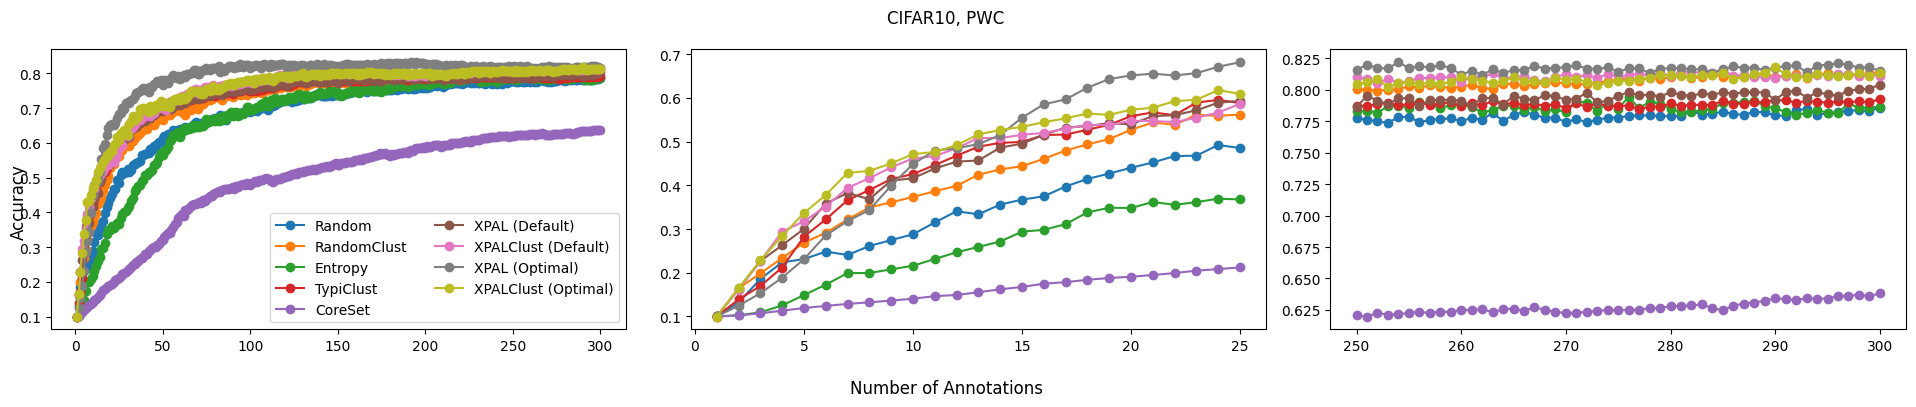

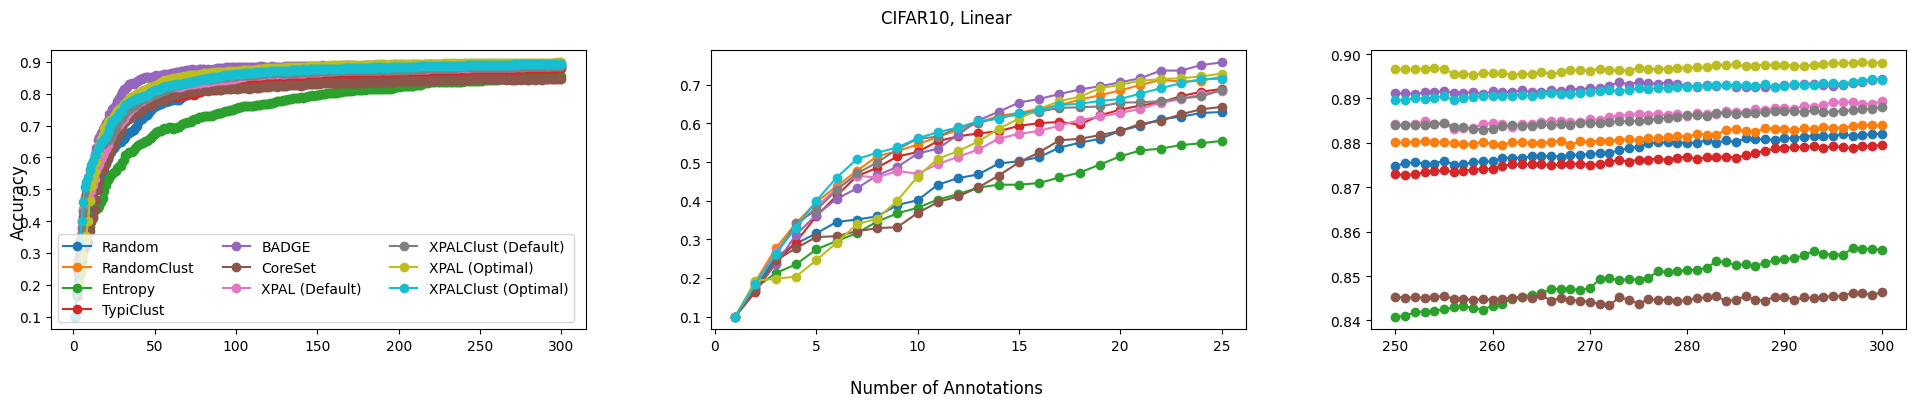

In [7]:
n_init=1
acq_size=1
n_acq=299


for model  in [Model.PWC, Model.Linear]:
    model_name = model.name
    model = model.value

    experiments = {
        "Random": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.RandomClust.value, Strategy.RandomClust.value, n_init, acq_size, n_acq),
        "Entropy": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Entropy.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "TypiClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.TypiClust.value, Strategy.TypiClust.value, n_init, acq_size, n_acq),
        "BADGE": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.BADGE.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "CoreSet": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.CoreSet.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "XPAL (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.XPAL.value, n_init, acq_size, n_acq, suffix="default"),
        "XPALClust (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.XPALClust.value, n_init, acq_size, n_acq, suffix="default"),
        "XPAL (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.XPAL.value, n_init, acq_size, n_acq, suffix="optimal"),
        "XPALClust (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.XPALClust.value, n_init, acq_size, n_acq, suffix="optimal"),
    }

    if model_name == "PWC":
        del experiments["BADGE"]

    # savePath = Path(os.path.join("learning_curves", Dataset.SVHN.value, model, f"budet{budget}.png"))
    # os.makedirs(os.path.join("learning_curves", Dataset.SVHN.value, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"CIFAR10, {model_name}", save=False, savePath="", plot_std=False, xlim=[None, (1, 25), (250, 300)])
    except FileNotFoundError as e:
        print(e)

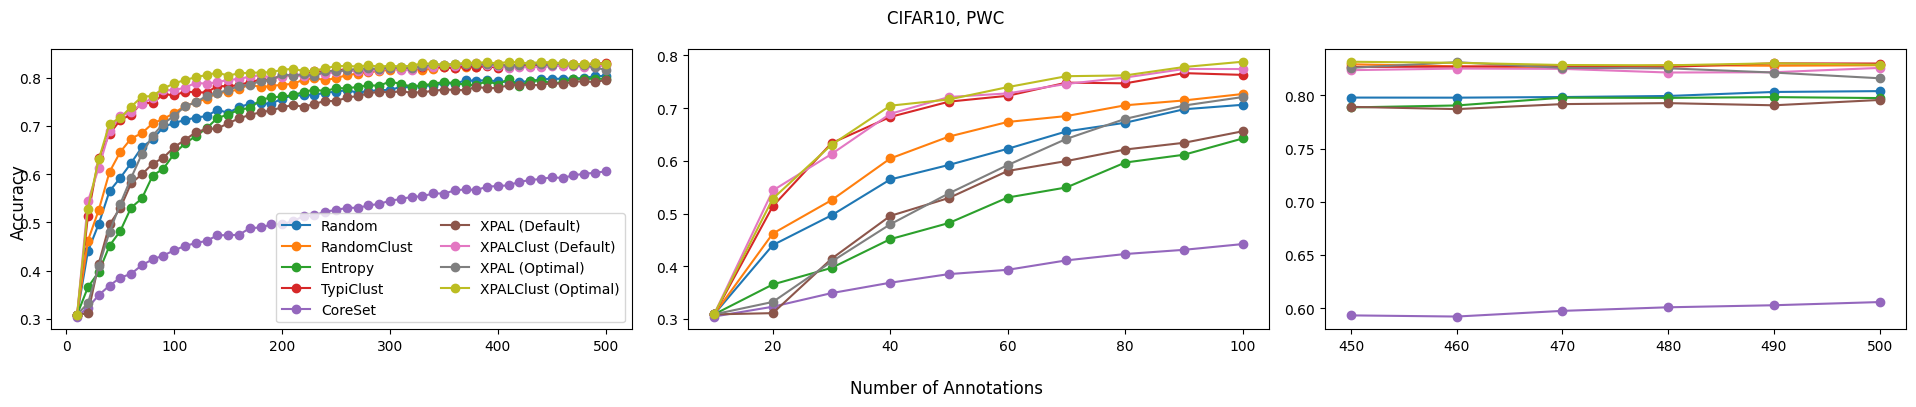

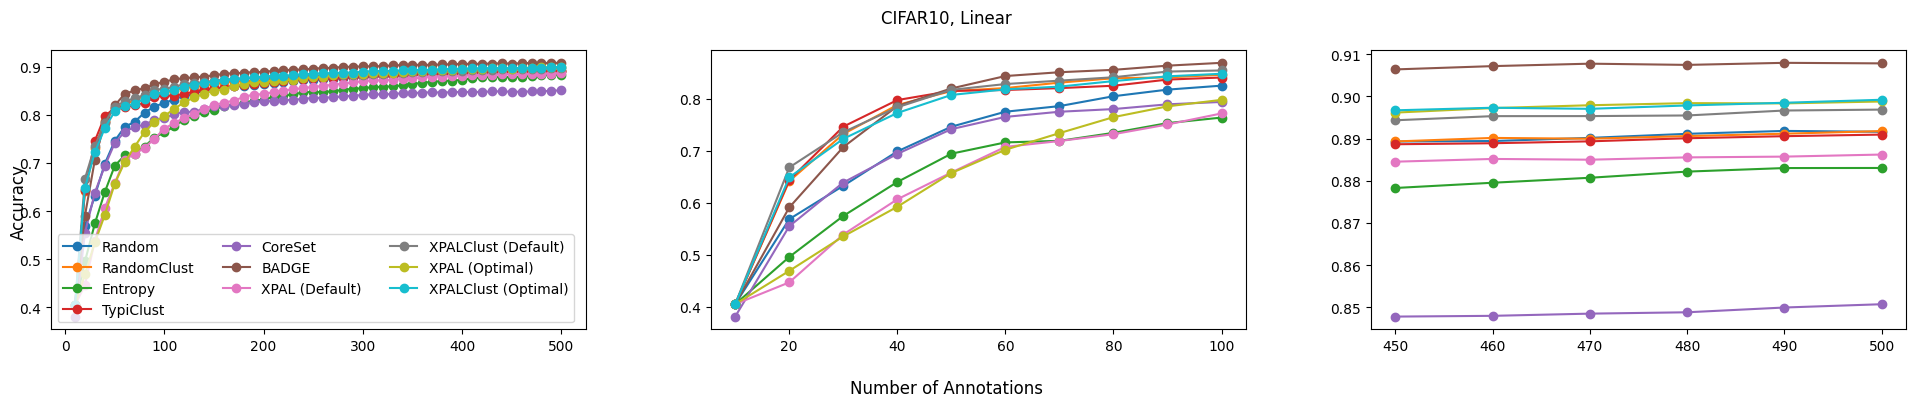

In [8]:
n_init=10
acq_size=10
n_acq=49


for model  in [Model.PWC, Model.Linear]:
    model_name = model.name
    model = model.value

    experiments = {
        "Random": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.RandomClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "Entropy": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Entropy.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "TypiClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.TypiClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "CoreSet": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.CoreSet.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "BADGE": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.BADGE.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "XPAL (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.Random.value, n_init, acq_size, n_acq, suffix="default"),
        "XPALClust (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.Random.value, n_init, acq_size, n_acq, suffix="default"),
        "XPAL (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.Random.value, n_init, acq_size, n_acq, suffix="optimal"),
        "XPALClust (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.Random.value, n_init, acq_size, n_acq, suffix="optimal"),
    }

    if model_name == "PWC":
        del experiments["BADGE"]

    # savePath = Path(os.path.join("learning_curves", Dataset.SVHN.value, model, f"budet{budget}.png"))
    # os.makedirs(os.path.join("learning_curves", Dataset.SVHN.value, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"CIFAR10, {model_name}", save=False, savePath="", plot_std=False, xlim=[None, (10, 100), (450, 500)])
    except FileNotFoundError as e:
        print(e)

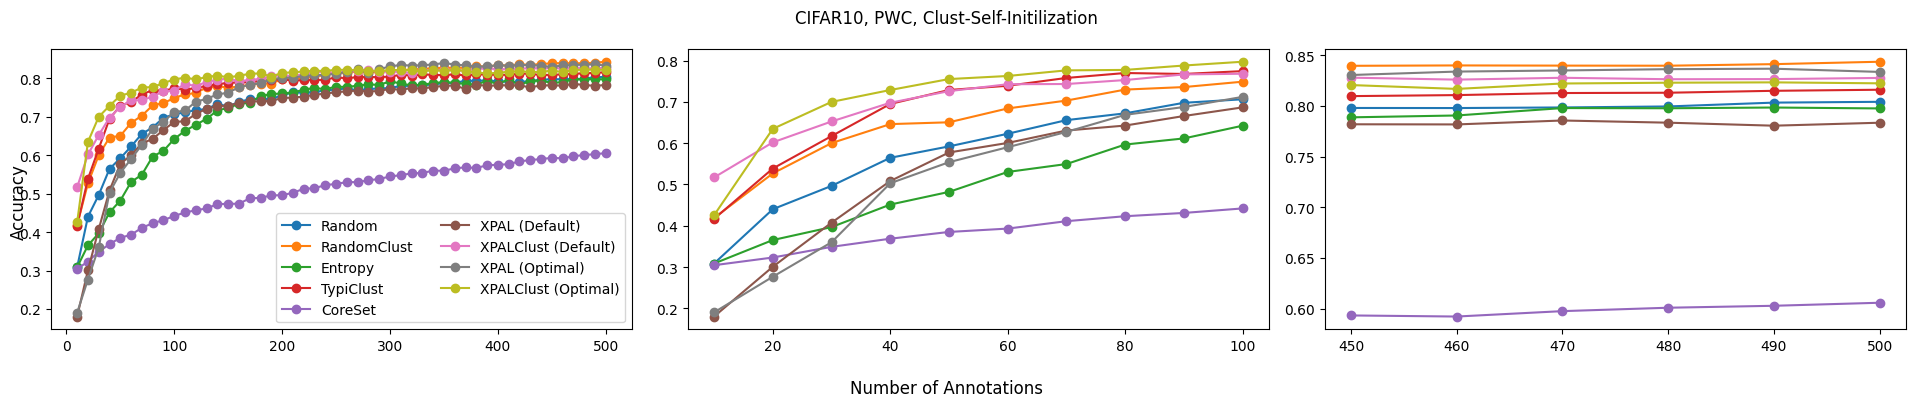

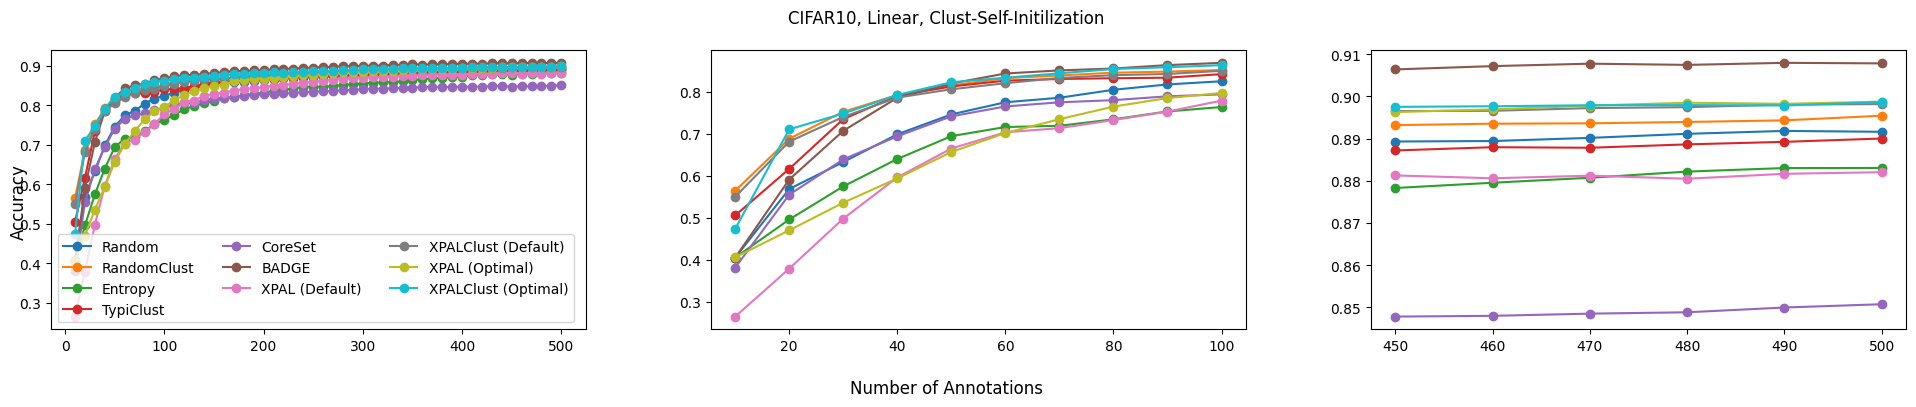

In [9]:
n_init=10
acq_size=10
n_acq=49


for model  in [Model.PWC, Model.Linear]:
    model_name = model.name
    model = model.value

    experiments = {
        "Random": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.RandomClust.value, Strategy.RandomClust.value, n_init, acq_size, n_acq),
        "Entropy": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.Entropy.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "TypiClust": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.TypiClust.value, Strategy.TypiClust.value, n_init, acq_size, n_acq),
        "CoreSet": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.CoreSet.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "BADGE": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.BADGE.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "XPAL (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.XPAL.value, n_init, acq_size, n_acq, suffix="default"),
        "XPALClust (Default)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.XPALClust.value, n_init, acq_size, n_acq, suffix="default"),
        "XPAL (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPAL.value, Strategy.XPAL.value, n_init, acq_size, n_acq, suffix="optimal"),
        "XPALClust (Optimal)": create_new_results_path(Dataset.CIFAR10.value, model, Strategy.XPALClust.value, Strategy.XPALClust.value, n_init, acq_size, n_acq, suffix="optimal"),
    }

    if model_name == "PWC":
        del experiments["BADGE"]

    # savePath = Path(os.path.join("learning_curves", Dataset.SVHN.value, model, f"budet{budget}.png"))
    # os.makedirs(os.path.join("learning_curves", Dataset.SVHN.value, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"CIFAR10, {model_name}, Clust-Self-Initilization", save=False, savePath="", plot_std=False, xlim=[None, (10, 100), (450, 500)])
    except FileNotFoundError as e:
        print(e)

### SVHN Fully supervised

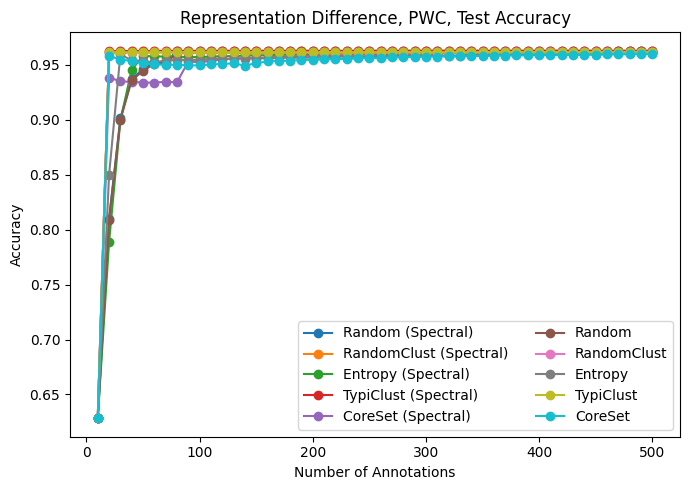

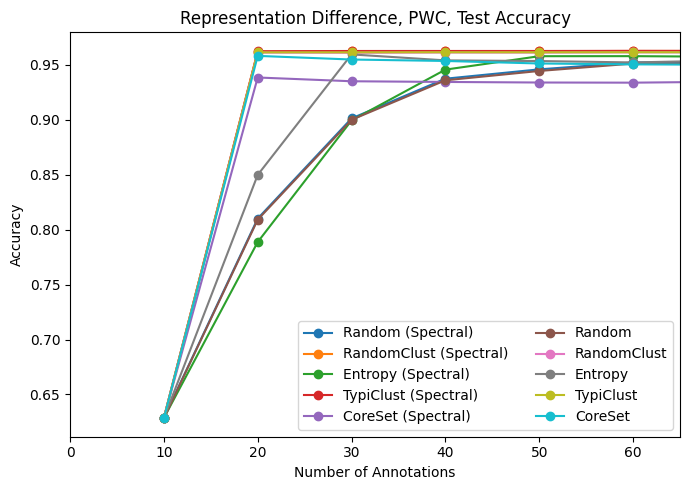

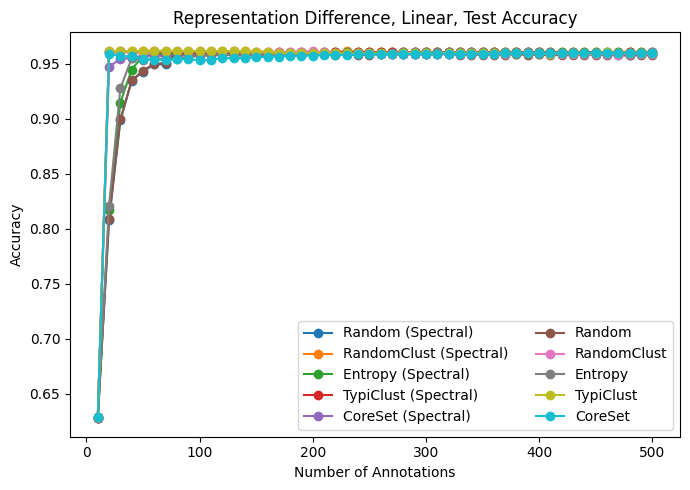

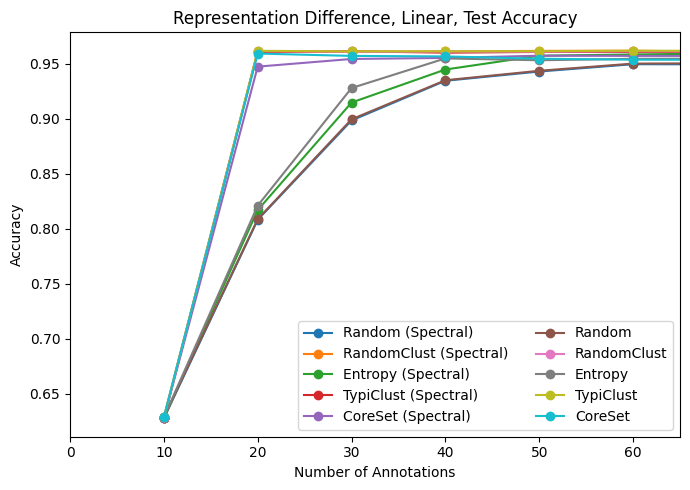

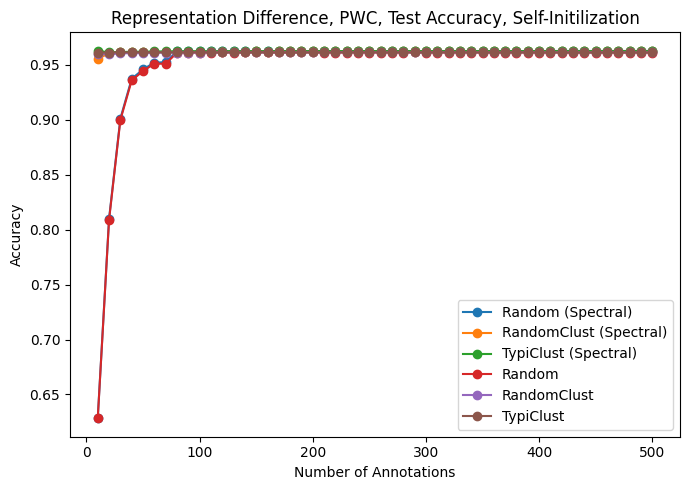

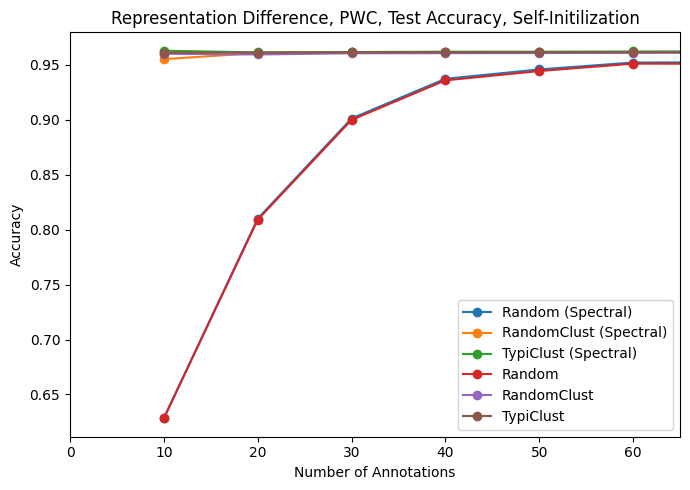

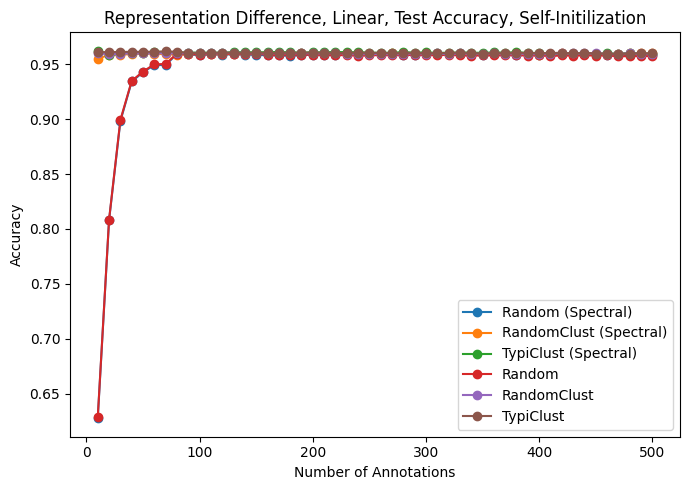

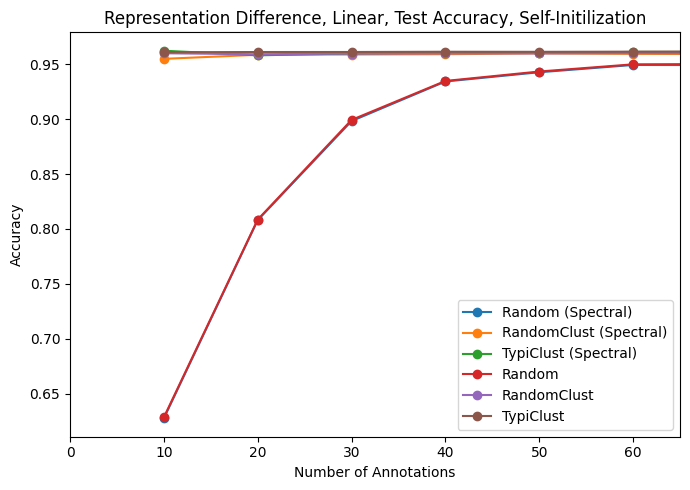

In [53]:
n_init=10
acq_size=10
n_acq=49


for model  in [Model.PWC, Model.Linear]:
    model_name = model.name
    model = model.value

    experiments = {
        "Random (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.RandomClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "Entropy (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.Entropy.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "TypiClust (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.TypiClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "CoreSet (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.CoreSet.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "Random": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.RandomClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "Entropy": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.Entropy.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "TypiClust": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.TypiClust.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "CoreSet": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.CoreSet.value, Strategy.Random.value, n_init, acq_size, n_acq),
        # "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        # "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    # savePath = Path(os.path.join("learning_curves", Dataset.SVHN.value, model, f"budet{budget}.png"))
    # os.makedirs(os.path.join("learning_curves", Dataset.SVHN.value, model), exist_ok=True)

    try:
        exps = generate_learning_curves(experiments)
        plot_learning_curves(exps, title = f"Representation Difference, {model_name}, Test Accuracy", save=False, savePath="", plot_std=False)
        plot_learning_curves(exps, title = f"Representation Difference, {model_name}, Test Accuracy", save=False, savePath="", plot_std=False, xlim=(0, 65))
    except FileNotFoundError as e:
        print(e)

for model  in [Model.PWC, Model.Linear]:
    model_name = model.name
    model = model.value

    experiments = {
        "Random (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.RandomClust.value, Strategy.RandomClust.value, n_init, acq_size, n_acq),
        "TypiClust (Spectral)": create_new_results_path(Dataset.SVHN_spectral_supervised.value, model, Strategy.TypiClust.value, Strategy.TypiClust.value, n_init, acq_size, n_acq),
        "Random": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.Random.value, Strategy.Random.value, n_init, acq_size, n_acq),
        "RandomClust": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.RandomClust.value, Strategy.RandomClust.value, n_init, acq_size, n_acq),
        "TypiClust": create_new_results_path(Dataset.SVHN_supervised.value, model, Strategy.TypiClust.value, Strategy.TypiClust.value, n_init, acq_size, n_acq),
        # "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        # "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    # savePath = Path(os.path.join("learning_curves", Dataset.SVHN.value, model, f"budet{budget}.png"))
    # os.makedirs(os.path.join("learning_curves", Dataset.SVHN.value, model), exist_ok=True)

    try:
        exps = generate_learning_curves(experiments)
        plot_learning_curves(exps, title = f"Representation Difference, {model_name}, Test Accuracy, Self-Initilization", save=False, savePath="", plot_std=False)
        plot_learning_curves(exps, title = f"Representation Difference, {model_name}, Test Accuracy, Self-Initilization", save=False, savePath="", plot_std=False, xlim=(0, 65))
    except FileNotFoundError as e:
        print(e)

## XPAL Comparison

### Comparison

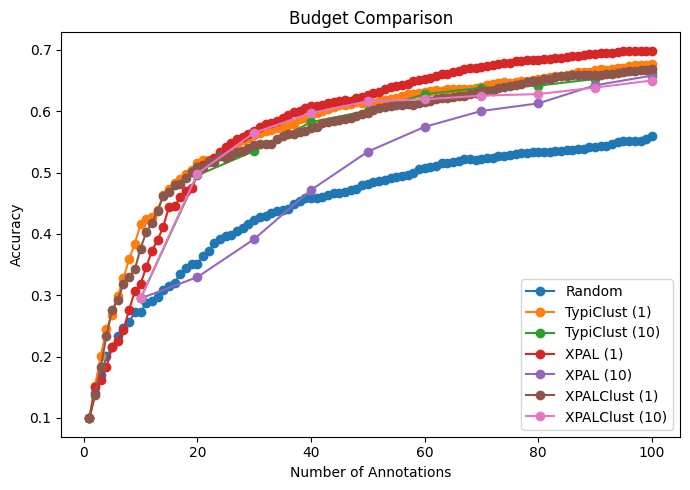

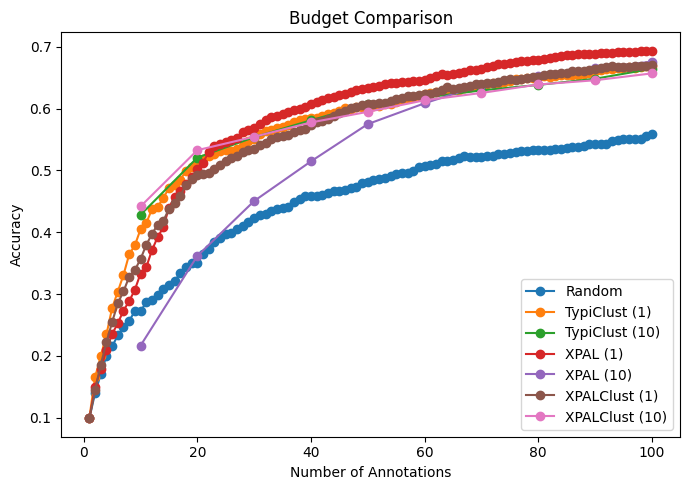

In [6]:
# Generating XPAL Comparison

experiments = {
    "Random": create_results_path("CIFAR10" ,"pwc", Strategy.Random.value, "100_acq_1"),
    "TypiClust (1)": create_results_path("CIFAR10", "pwc", Strategy.TypiClust.value, "100_acq_1"),
    "TypiClust (10)": create_results_path("CIFAR10", "pwc", Strategy.TypiClust.value, "100"),
    "XPAL (1)": create_results_path("CIFAR10", "pwc", Strategy.XPAL.value, "100_acq_1"),
    "XPAL (10)": create_results_path("CIFAR10", "pwc", Strategy.XPAL.value, "100"),
    "XPALClust (1)": create_results_path("CIFAR10", "pwc", Strategy.XPALClust.value, "100_acq_1"),
    "XPALClust (10)": create_results_path("CIFAR10", "pwc", Strategy.XPALClust.value, "100"),
}

plot_learning_curves(generate_learning_curves(experiments), title = f"Budget Comparison", save=False, plot_std=False)

experiments = {
    "Random": create_results_path("CIFAR10" ,"pwc", Strategy.Random.value, "100_acq_1_self_initialization"),
    "TypiClust (1)": create_results_path("CIFAR10", "pwc", Strategy.TypiClust.value, "100_acq_1_self_initialization"),
    "TypiClust (10)": create_results_path("CIFAR10", "pwc", Strategy.TypiClust.value, "100_self_initialization"),
    "XPAL (1)": create_results_path("CIFAR10", "pwc", Strategy.XPAL.value, "100_acq_1_self_initialization"),
    "XPAL (10)": create_results_path("CIFAR10", "pwc", Strategy.XPAL.value, "100_self_initialization"),
    "XPALClust (1)": create_results_path("CIFAR10", "pwc", Strategy.XPALClust.value, "100_acq_1_self_initialization"),
    "XPALClust (10)": create_results_path("CIFAR10", "pwc", Strategy.XPALClust.value, "100_self_initialization"),
}

plot_learning_curves(generate_learning_curves(experiments), title = f"Budget Comparison", save=False, plot_std=False)

### Budget 100

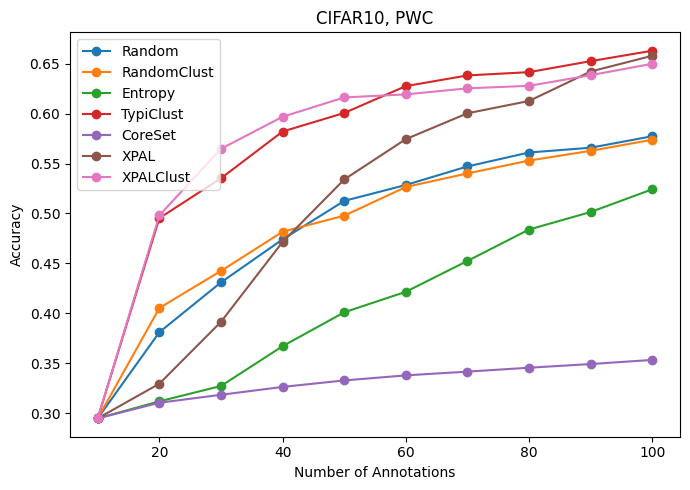

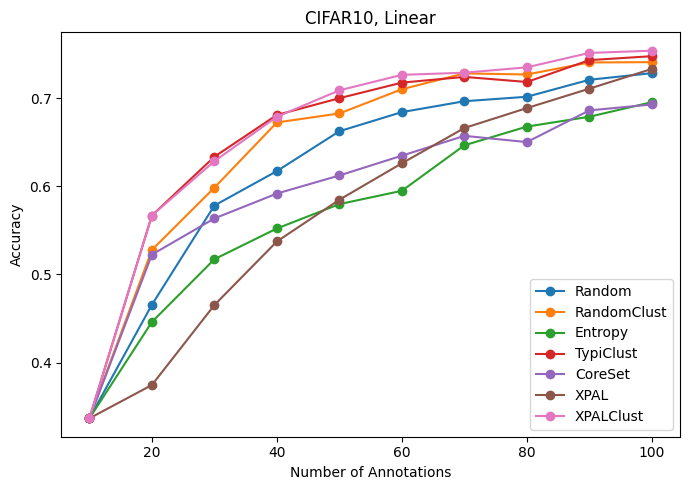

In [7]:
budget = "100"

for dataset, model  in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "RandomClust": create_results_path(dataset, model, Strategy.RandomClust.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "CoreSet": create_results_path(dataset, model, Strategy.CoreSet.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
        # "XPAL (Full)": create_results_path(dataset, model, Strategy.XPAL_NONE.value, budget)
    }

    if model == Model.PWC_Standardized.value:
        continue
        del experiments["XPALClust"]
        del experiments["RandomClust"]

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name}", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

### Budget 100 Self Initialization

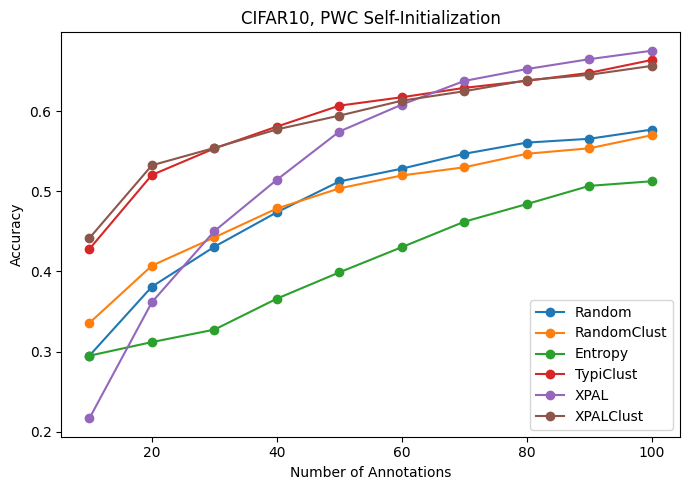

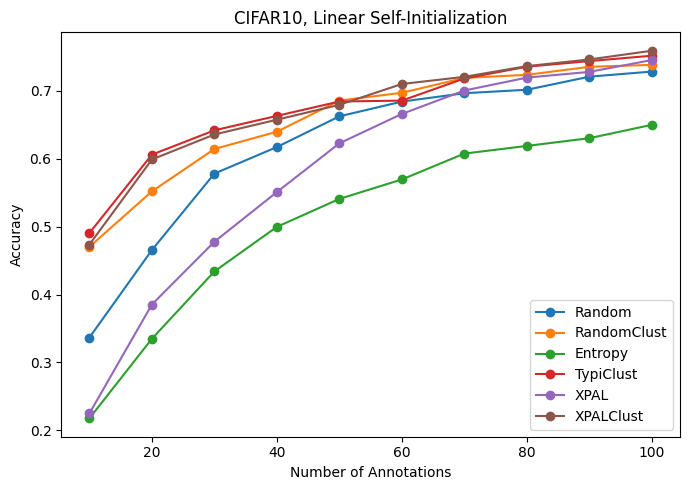

In [8]:
budget = "100_self_initialization"

for dataset, model  in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    if model == Model.PWC_Standardized.value:
        continue

    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "RandomClust": create_results_path(dataset, model, Strategy.RandomClust.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name} Self-Initialization", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

### Budget 100 Acq 1

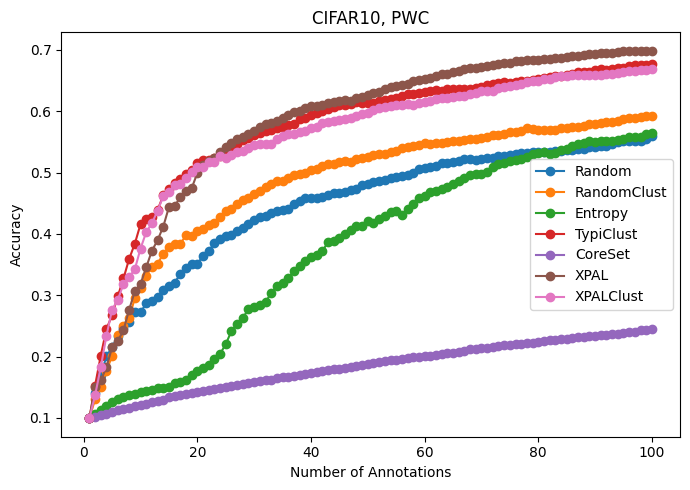

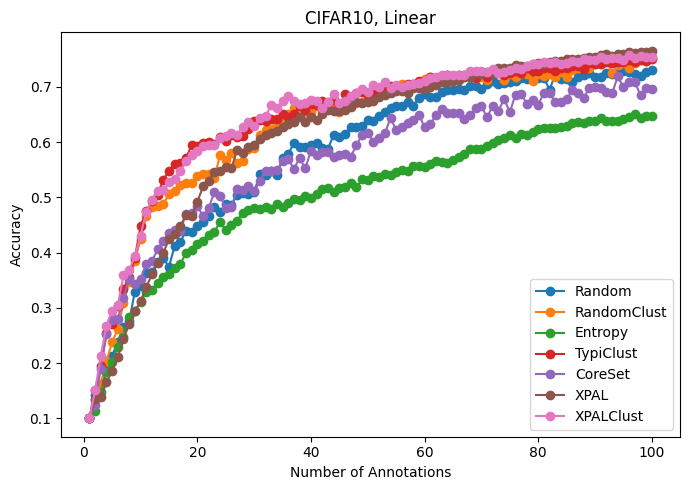

In [9]:
budget = "100_acq_1"

for dataset, model  in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    if model == Model.PWC_Standardized.value:
        continue


    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "RandomClust": create_results_path(dataset, model, Strategy.RandomClust.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "CoreSet": create_results_path(dataset, model, Strategy.CoreSet.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    if model == Model.PWC_Standardized.value:
        del experiments["XPALClust"]

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name}", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

### Budget 100 Acq 1 Self Initialization

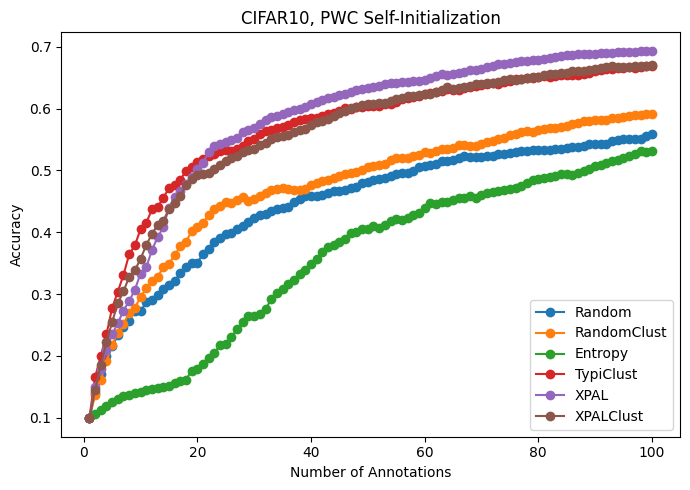

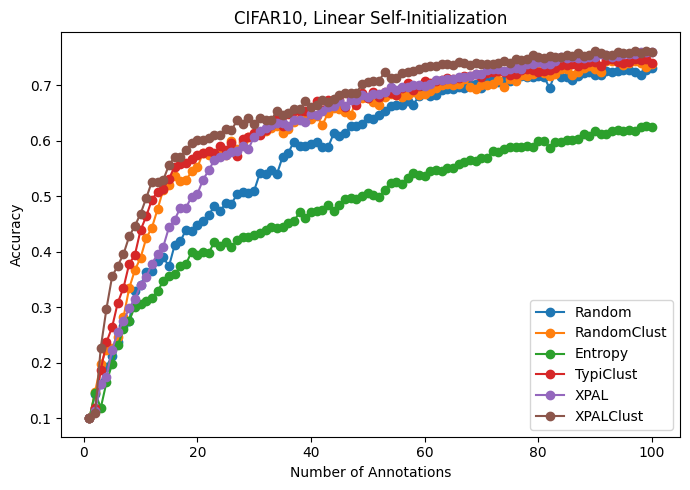

In [10]:
budget = "100_acq_1_self_initialization"

for dataset, model  in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    if model == Model.PWC_Standardized.value:
        continue

    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "RandomClust": create_results_path(dataset, model, Strategy.RandomClust.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name} Self-Initialization", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

### Budget 300 Acq 1 Self Initialization

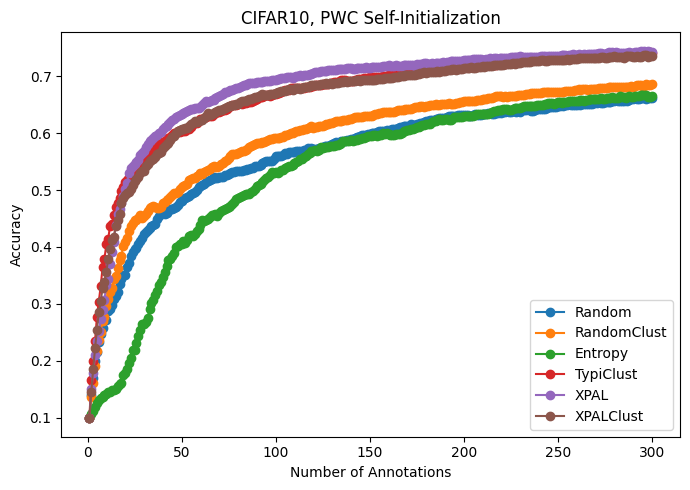

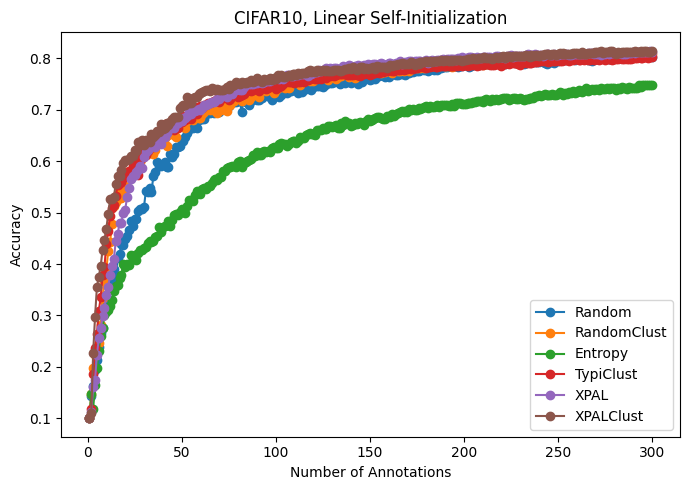

In [11]:
budget = "300_acq_1_self_initialization"

for dataset, model  in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    if model == Model.PWC_Standardized.value:
        continue

    experiments = {
        "Random": create_results_path(dataset, model, Strategy.Random.value, budget),
        "RandomClust": create_results_path(dataset, model, Strategy.RandomClust.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPALClust": create_results_path(dataset, model, Strategy.XPALClust.value, budget),
    }

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name} Self-Initialization", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

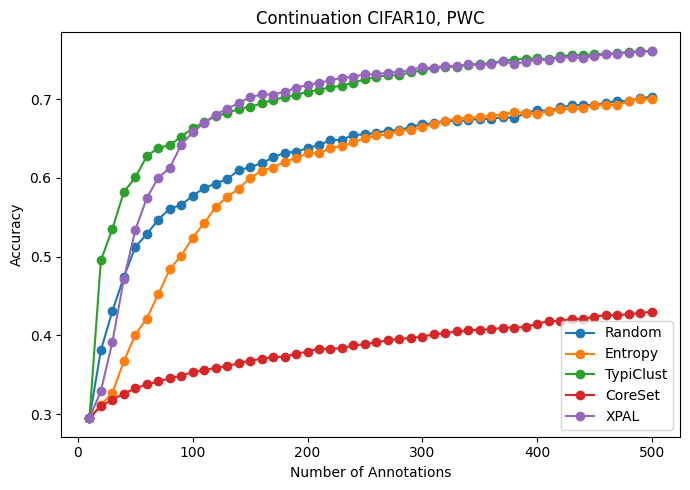

In [12]:
# Budget 500

experiments = {
    "Random": create_results_path(dataset, "pwc", Strategy.Random.value, 500),
    "Entropy": create_results_path(dataset, "pwc", Strategy.Entropy.value, 500),
    "TypiClust": create_results_path(dataset, "pwc", Strategy.TypiClust.value, 500),
    "CoreSet": create_results_path(dataset, "pwc", Strategy.CoreSet.value, 500),
    "XPAL": create_results_path(dataset, "pwc", Strategy.XPAL.value, 500),
}
try:
    plot_learning_curves(generate_learning_curves(experiments), title = f"Continuation CIFAR10, PWC", save=False, plot_std=False)
except FileNotFoundError as e:
    print(e)

## XPAL Hparams

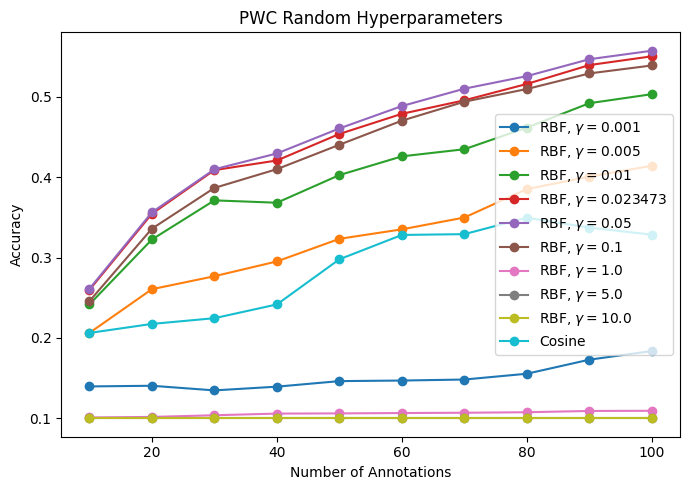

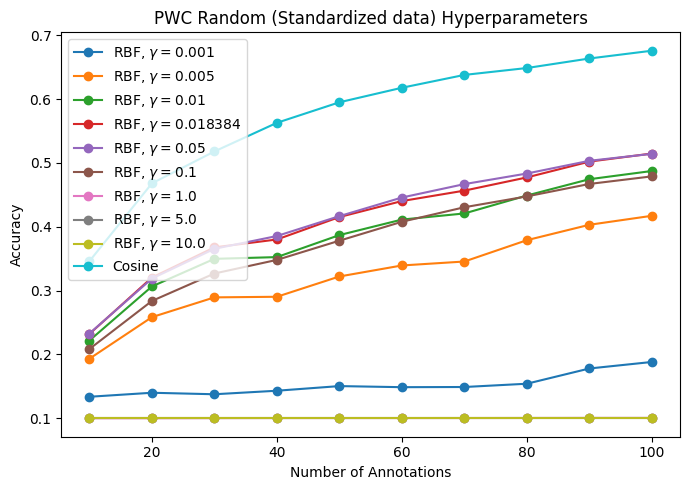

In [11]:
rbf_gammas = (0.001, 0.005, 0.01, 0.023473, 0.05, 0.1, 1.0, 5.0, 10.0)

experiments = {"RBF, $\gamma=$" + str(gamma):xpal_haparams_path("rbf", str(gamma)) for gamma in rbf_gammas}
experiments["Cosine"] = xpal_haparams_path("cosine")

try:
    plot_learning_curves(generate_learning_curves(experiments), title = "PWC Random Hyperparameters", save=True, savePath=savePath, plot_std=False)
except FileNotFoundError as e:
    print(e)

rbf_gammas = (0.001, 0.005, 0.01, 0.018384, 0.05, 0.1, 1.0, 5.0, 10.0)

experiments = {"RBF, $\gamma=$" + str(gamma):xpal_haparams_standardized_path("rbf", str(gamma)) for gamma in rbf_gammas}
experiments["Cosine"] = xpal_haparams_standardized_path("cosine")

try:
    plot_learning_curves(generate_learning_curves(experiments), title = "PWC Random (Standardized data) Hyperparameters", save=False, plot_std=False)
except FileNotFoundError as e:
    print(e)

In [12]:
rbf_gammas = (0.001, 0.005, 0.01, "calculate", 0.05, 0.1, 1.0, 5.0, 10.0)
alphas= ("1e-3", "1e-5", "1e-7", "1e-9", "1e-10", "1e-11", "1e-12", "1e-16")

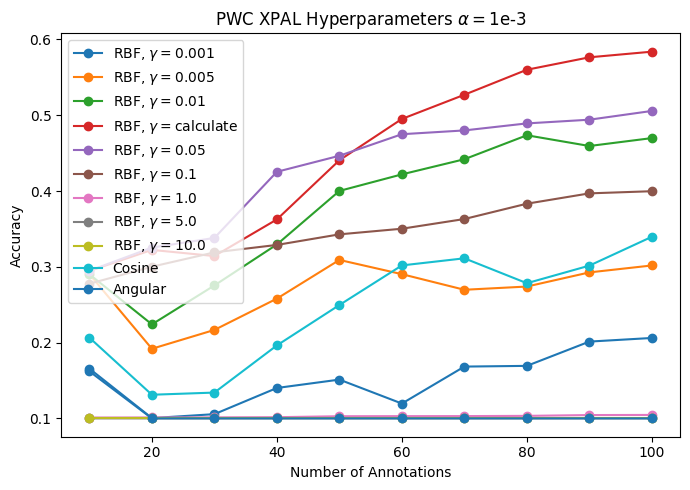

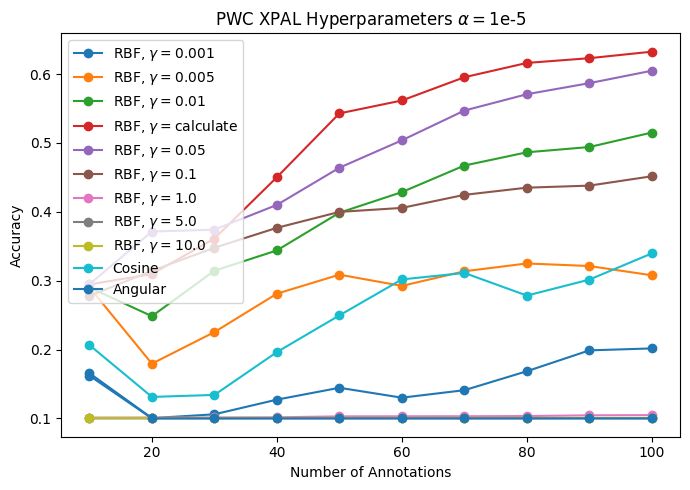

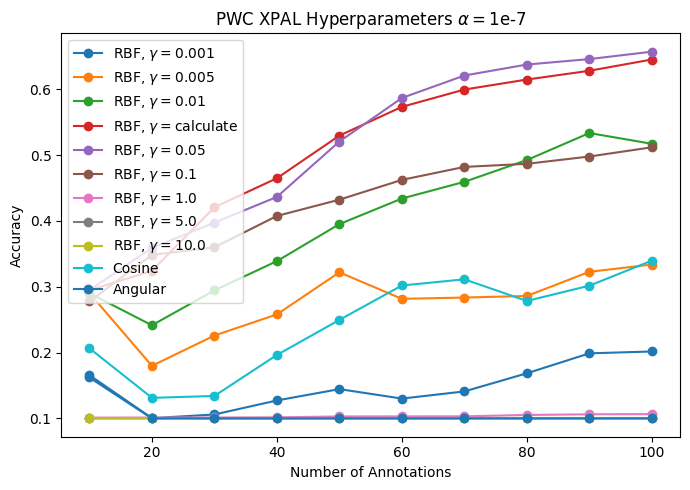

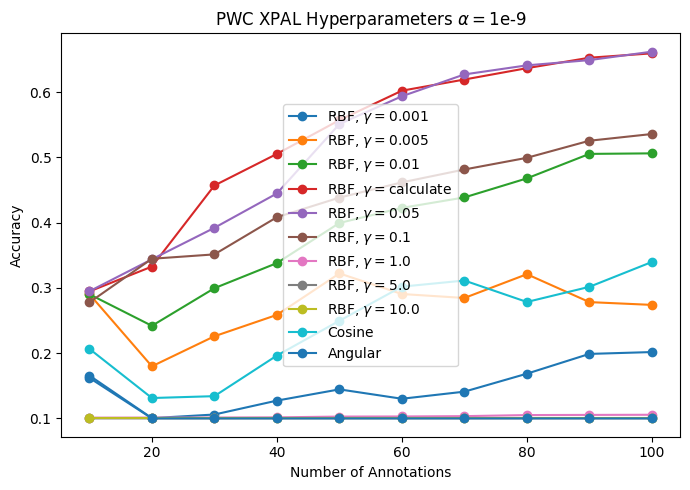

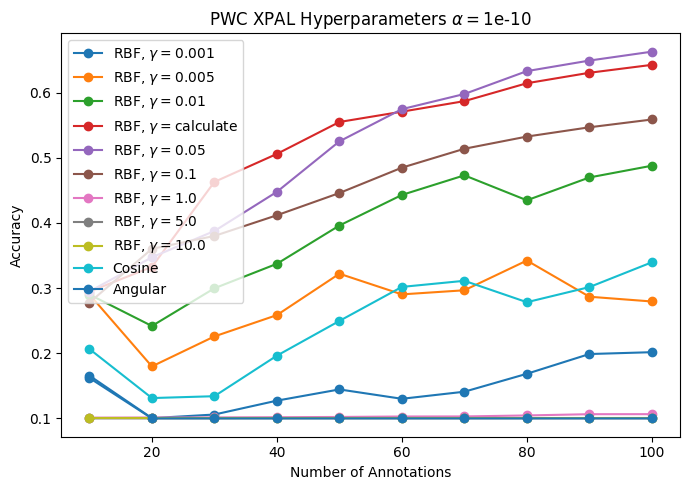

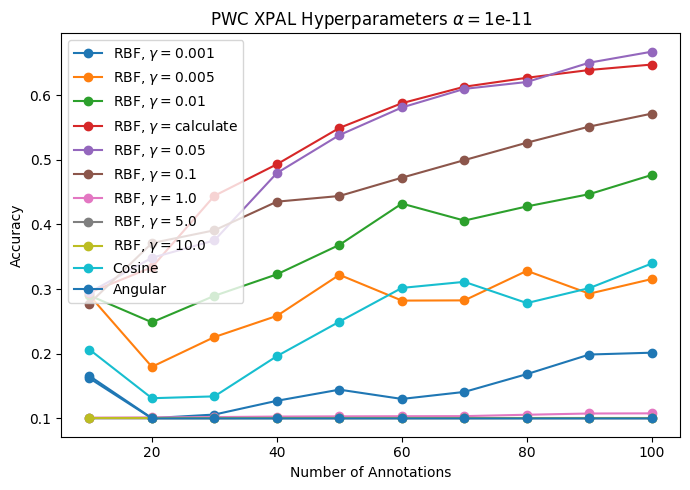

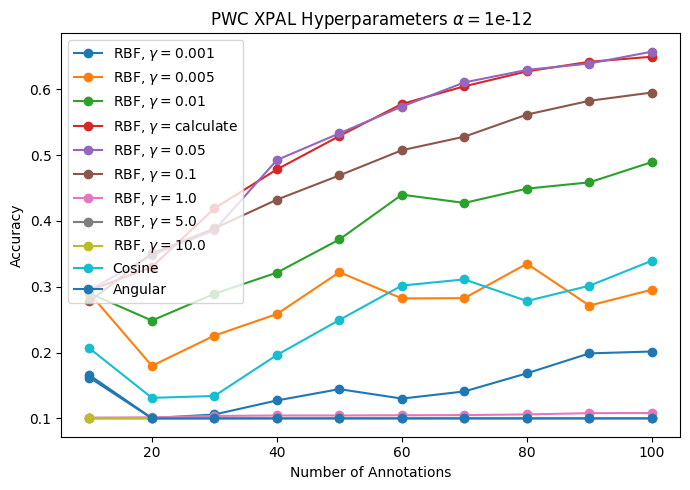

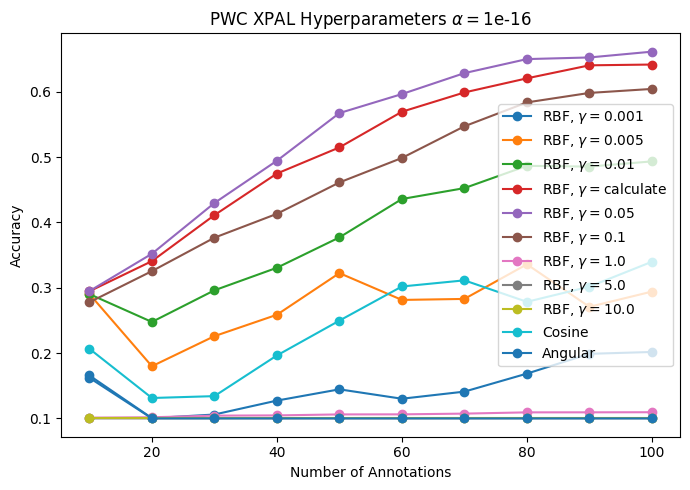

In [13]:
for alpha in alphas:
    experiments = {f"RBF, $\gamma=${str(gamma)}":xpal_haparams_new_path("rbf", str(gamma), alpha) for gamma in rbf_gammas}
    experiments.update({f"Cosine":xpal_haparams_new_path("cosine", alpha=alpha)})
    experiments.update({f"Angular":xpal_haparams_new_path("angular", alpha=alpha)})
    
    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"PWC XPAL Hyperparameters $\\alpha=${alpha}", save=False, plot_std=False)
    except FileNotFoundError as e:
        print(e)

In [14]:
experiments = {f"RBF, $\gamma=${str(gamma)}, $\\alpha=${alpha}":xpal_haparams_new_path("rbf", str(gamma), alpha) for gamma in rbf_gammas for alpha in alphas}
exps = generate_learning_curves(experiments)

_max = None
max_acc = 0
for key, value in exps.items():
    if value["acc"][-1] > max_acc:
        _max = key
        max_acc = value["acc"][-1]

print(f"Max final accuracy: {max_acc} reached with_ {_max}")

Max final accuracy: 0.6673199892044067 reached with_ RBF, $\gamma=$0.05, $\alpha=$1e-11


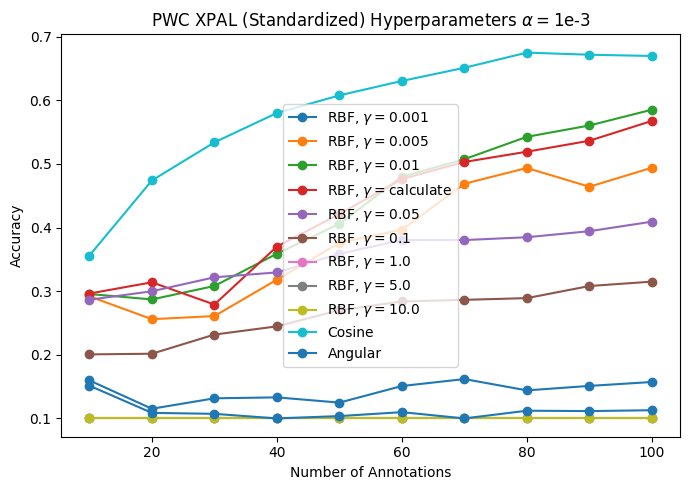


KeyboardInterrupt



In [15]:
for alpha in alphas:
    experiments = {f"RBF, $\gamma=${str(gamma)}":xpal_haparams_new_stand_path("rbf", str(gamma), alpha) for gamma in rbf_gammas}
    experiments.update({f"Cosine":xpal_haparams_new_stand_path("cosine", alpha=alpha)})
    experiments.update({f"Angular":xpal_haparams_new_stand_path("angular", alpha=alpha)})
    
    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"PWC XPAL (Standardized) Hyperparameters $\\alpha=${alpha}", save=False, plot_std=False)
    except FileNotFoundError as e:
        print(e)

In [ ]:
rbf_gammas = ("calculate", 0.05)
alphas= ("1e-3", "1e-5", "1e-7", "1e-9", "1e-10", "1e-11", "1e-12", "1e-16")

experiments = {f"RBF, $\gamma=${str(gamma)}, $\\alpha=${alpha}":xpal_haparams_new_stand_path("rbf", str(gamma), alpha) for gamma in rbf_gammas for alpha in alphas}
experiments.update({f"Cosine $\\alpha=${alpha}":xpal_haparams_new_stand_path("cosine", alpha=alpha) for alpha in alphas})

exps = generate_learning_curves(experiments)

_max = None
max_acc = 0
for key, value in exps.items():
    if value["acc"][-1] > max_acc:
        _max = key
        max_acc = value["acc"][-1]

print(f"Max final accuracy: {max_acc} reached with_ {_max}")

## XPAL vs. TypiClust

In [ ]:
features_dir = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "data", "resnet18_cifar10_87_leacc.pth")
data_dir = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "data")

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_image_batch(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

def get_class_distribution_and_images(dataset, model, strategy, budget, seed, features_dir=features_dir):
    # Get data representation and labels
    seed_everything(seed)
    data = FeatureDatasetWrapper(features_dir)
    labels = np.array([int(label) for _, label in data.train_dataset])

    # Getting indices
    res_path = Path(os.path.join(base_results_path, dataset, model, strategy, f"budget_{budget}", f"seed{seed}", "queried_indices.json"))
    indices = load_json(res_path)
    chosen_labels = [labels[val] for val in indices.values()]

    # Getting images # Not working 
    # cifar = CIFAR10Plain(data_dir, seed=42)
    # images = torch.stack([img for img, _ in cifar.train_dataset])
    # chosen_images = [images[val] for val in indices.values()]
    chosen_images = None
    return chosen_labels, chosen_images

In [ ]:
seeds = [i for i in range(1, 11)]

typiclust = np.zeros(10)
xpal = np.zeros(10)

for seed in seeds:
    typi_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "typiclust", "100", seed)
    xpal_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "xpal", "100", seed)

    for typi_clycle, xpal_cylce in zip(typi_dist, xpal_dist):
        typi_labels, typi_counts = np.unique(typi_clycle, return_counts=True)
        xpal_labels, xpal_counts = np.unique(xpal_cylce, return_counts=True)
    
        typiclust[typi_labels] += typi_counts
        xpal[xpal_labels] += xpal_counts
        
fig, axes = plt.subplots(nrows=2)
labels = np.arange(10)

axes[0].bar(labels, typiclust, align='center')
axes[0].set_xticks([i for i in range(10)], cifar_classes)
axes[0].set_title("TypiClust")
axes[1].bar(labels, xpal, align='center')
axes[1].set_xticks([i for i in range(10)], cifar_classes)
axes[1].set_title("XPAL")
fig.suptitle("10 Sample per Cycle")
fig.tight_layout()
plt.show()

In [ ]:
seeds = [i for i in range(1, 11)]

typiclust = np.zeros(10)
xpal = np.zeros(10)

for seed in seeds:
    typi_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "typiclust", "100_acq_1", seed)
    xpal_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "xpal", "100_acq_1", seed)

    for typi_clycle, xpal_cylce in zip(typi_dist, xpal_dist):
        typi_labels, typi_counts = np.unique(typi_clycle, return_counts=True)
        xpal_labels, xpal_counts = np.unique(xpal_cylce, return_counts=True)
    
        typiclust[typi_labels] += typi_counts
        xpal[xpal_labels] += xpal_counts
        
fig, axes = plt.subplots(nrows=2)
labels = np.arange(10)

axes[0].bar(labels, typiclust, align='center')
axes[0].set_xticks([i for i in range(10)], cifar_classes)
axes[0].set_title("TypiClust")
axes[1].bar(labels, xpal, align='center')
axes[1].set_xticks([i for i in range(10)], cifar_classes)
axes[1].set_title("XPAL")
fig.suptitle("1 Sample per Cycle")
fig.tight_layout()
plt.show()

In [ ]:
seeds = [i for i in range(1, 11)]

typiclust = [np.zeros(10) for i in range(10)]
xpal = [np.zeros(10) for i in range(10)]

for seed in seeds:
    typi_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "typiclust", "100", seed)
    xpal_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "xpal", "100", seed)

    for idx, (typi_clycle, xpal_cylce) in enumerate(zip(typi_dist, xpal_dist)):
        typi_labels, typi_counts = np.unique(typi_clycle, return_counts=True)
        xpal_labels, xpal_counts = np.unique(xpal_cylce, return_counts=True)
    
        typiclust[idx][typi_labels] += typi_counts
        xpal[idx][xpal_labels] += xpal_counts

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(12, 24))
labels = np.arange(10)
for i in range(10):
    axes[i][0].bar(labels, typiclust[i], align='center')
    axes[i][0].set_xticks([i for i in range(10)], cifar_classes)
    axes[i][0].set_title(f"TypiClust Cycle {i}")
    axes[i][1].bar(labels, xpal[i], align='center')
    axes[i][1].set_xticks([i for i in range(10)], cifar_classes)
    axes[i][1].set_title(f"XPAL Cycle {i}")
fig.tight_layout()
plt.show()